In [1]:
# import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import datetime as dt
import seaborn as sns
import os
import glob
import re
import random
import bisect
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
import folium
from folium import plugins
import matplotlib.colors as mcolors

2024-12-12 21:41:04.039393: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 21:41:04.041892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 21:41:04.099370: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 21:41:04.100709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 21:41:05.774649: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load the datasets of origins
folder_path = "Origins"
file_paths = glob.glob(os.path.join(folder_path, "*.csv"))
origins = []
for file_path in file_paths:
    # Load CSV file using pandas (for renaming columns)
    df = pd.read_csv(file_path)
    df['started_at'] = pd.to_datetime(df['started_at'], format = 'ISO8601')
    df['ended_at'] = pd.to_datetime(df['ended_at'], format = 'ISO8601')
    df.head(10)
    origins.append(df)
origins.sort(key=lambda d: np.unique(d['start_station_name']))
print(f'{len(origins)} origin stations')

# Load the datasets of destinations
folder_path = "Destinations"
file_paths = glob.glob(os.path.join(folder_path, "*.csv"))
destinations = []
for file_path in file_paths:
    # Load CSV file using pandas (for renaming columns)
    df = pd.read_csv(file_path)
    df.head(10)
    df['started_at'] = pd.to_datetime(df['started_at'], format = 'ISO8601')
    df['ended_at'] = pd.to_datetime(df['ended_at'], format = 'ISO8601')
    destinations.append(df)
    
destinations.sort(key=lambda d: np.unique(d['end_station_name']))
print(f'{len(destinations)} destination stations')

# Load the dataframe of stations
stations = pd.read_csv('current_bluebikes_stations.csv')
stations = stations.sort_values('NAME')
stations = stations.reset_index(drop=True)
stations['Total Docks'] = (stations['Total Docks'].fillna(0)).astype(int)
stations['Seasonal Status'] = stations['Seasonal Status'].fillna('Unavailable')
print(f'{len(stations)} stations reported in blue-bike dataset')

# Detect and remove the uncoming stations that do not have enough/any trips
upcoming = []
for i in range(len(origins)):
    if stations['Number'][i] == "TBD - upcoming install":
        upcoming.append(i)
print('Upcoming stations:')
for u in upcoming:
    print(stations.NAME[u])

stations.drop(upcoming, inplace=True)
stations = stations.reset_index(drop=True)
origins = [i for j, i in enumerate(origins) if j not in upcoming]
destinations = [i for j, i in enumerate(destinations) if j not in upcoming]



/tmp/ipykernel_231300/898789907.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  origins.sort(key=lambda d: np.unique(d['start_station_name']))


491 origin stations
491 destination stations
491 stations reported in blue-bike dataset
Upcoming stations:
1515 Commonwealth Ave
99 Coolidge Ave
Arsenal on the Charles
Damrell St at Old Colony Ave
Melnea Cass Blvd at Hampden St
West Street


/tmp/ipykernel_231300/898789907.py:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  destinations.sort(key=lambda d: np.unique(d['end_station_name']))


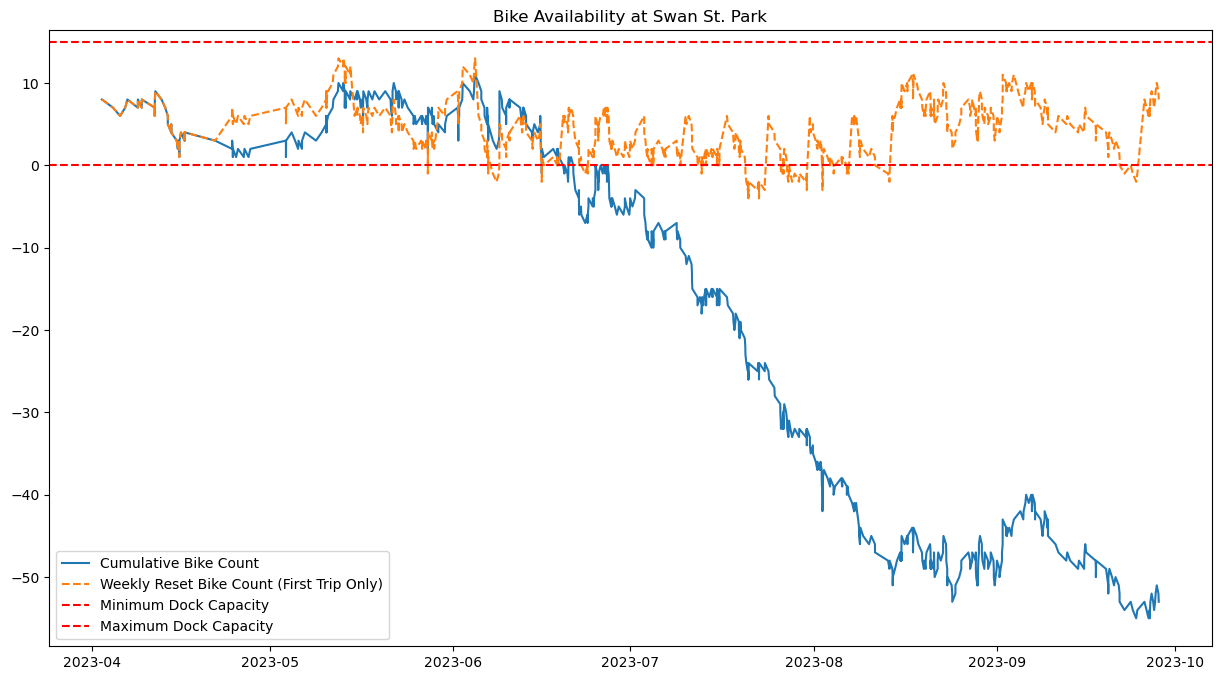

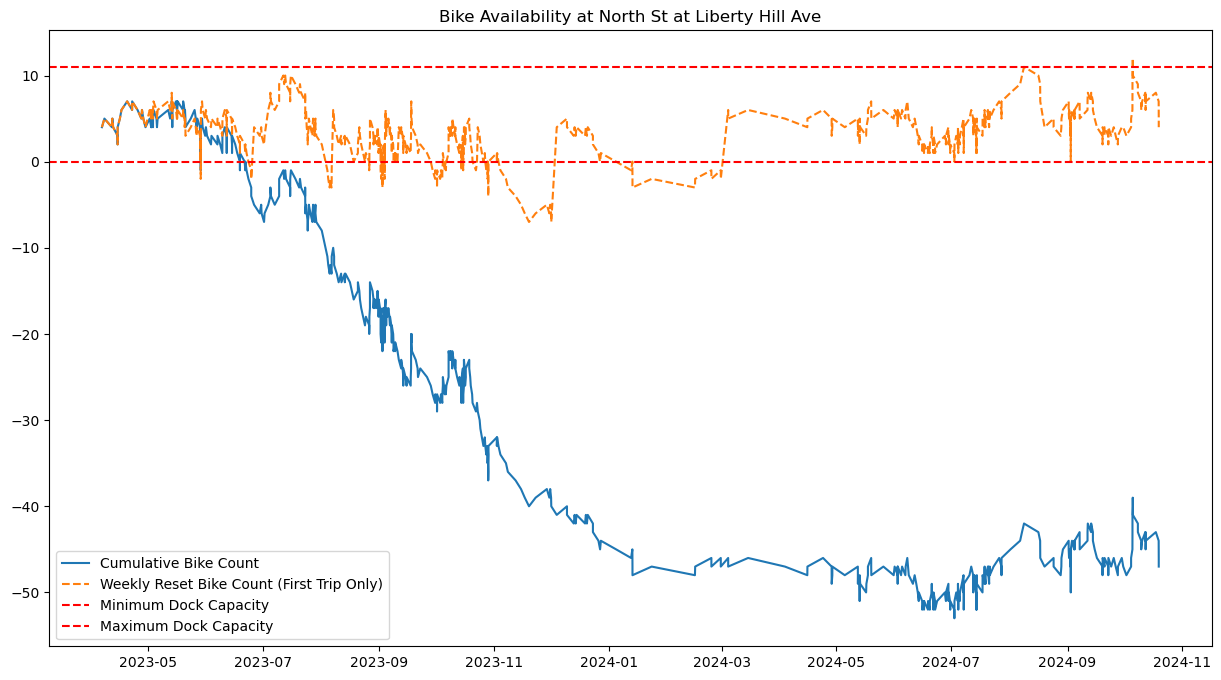

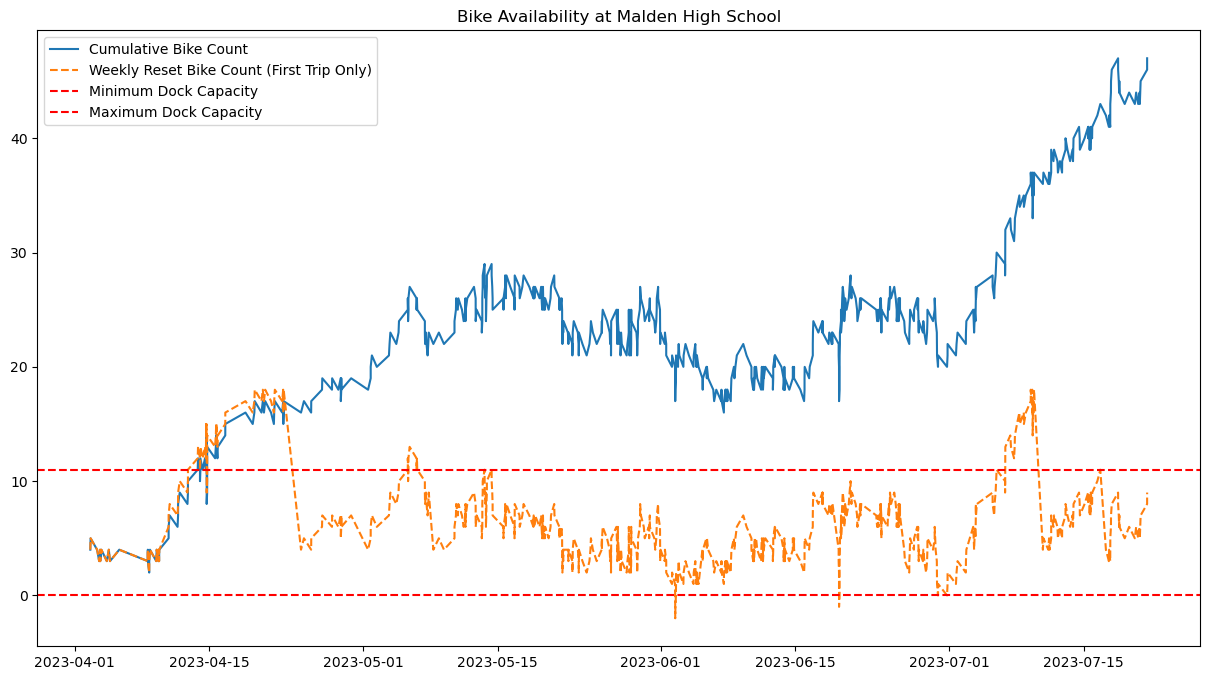

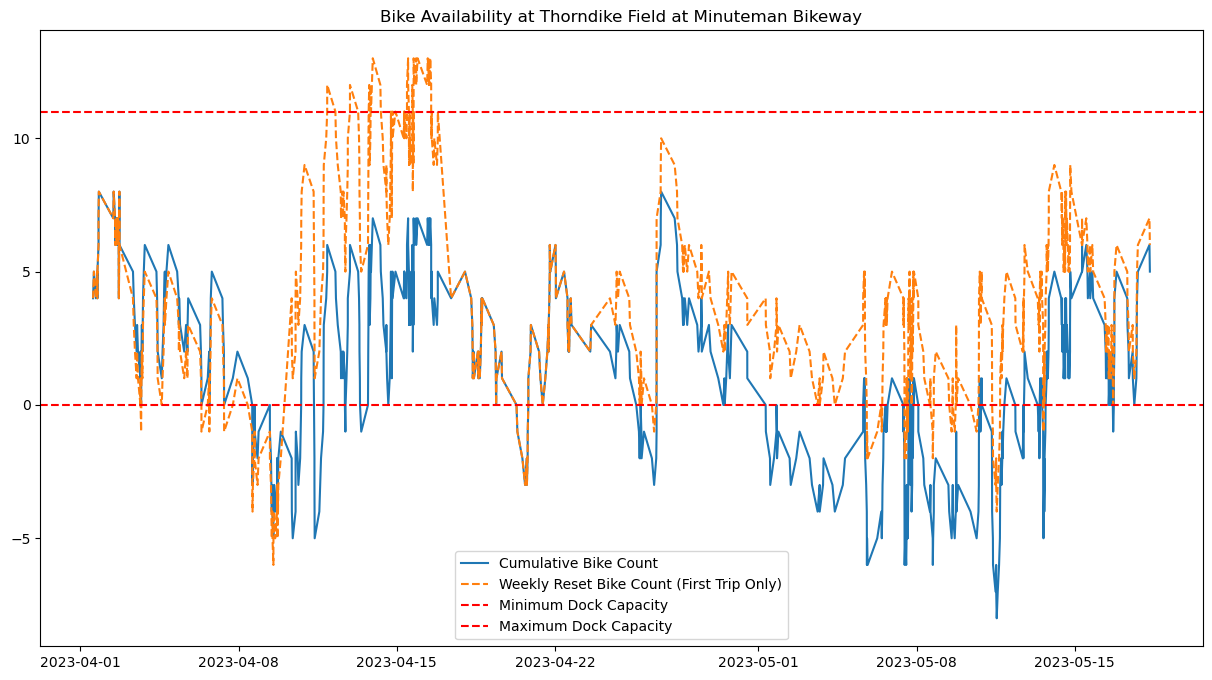

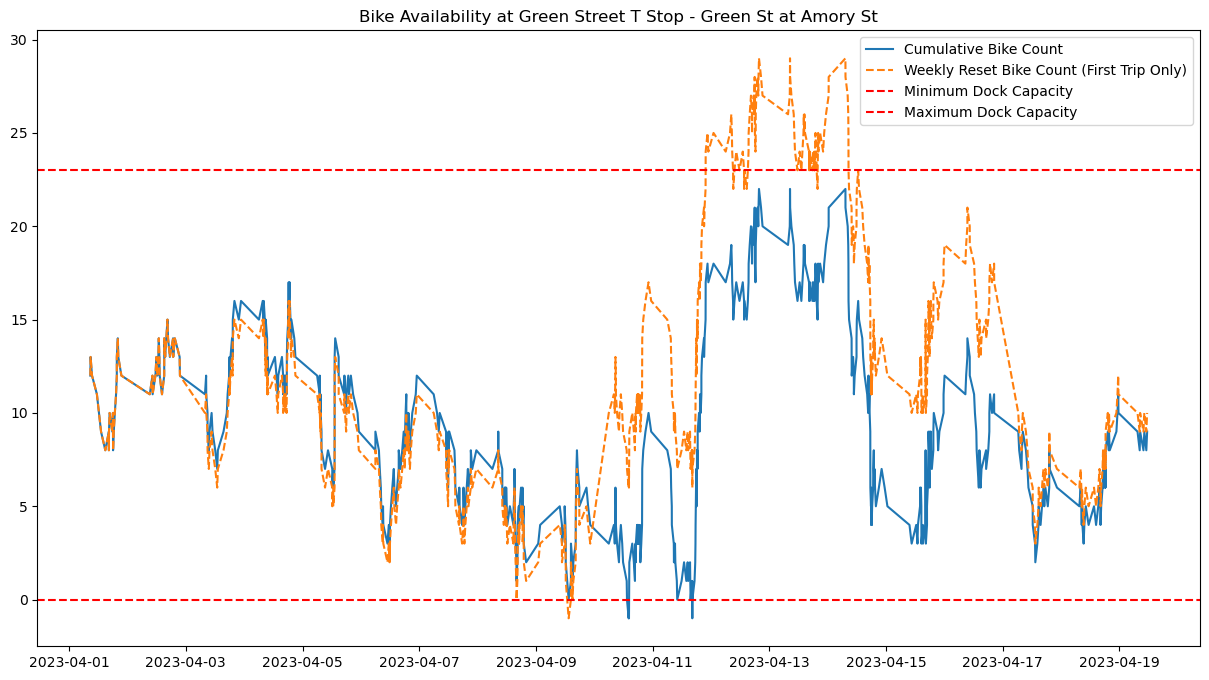

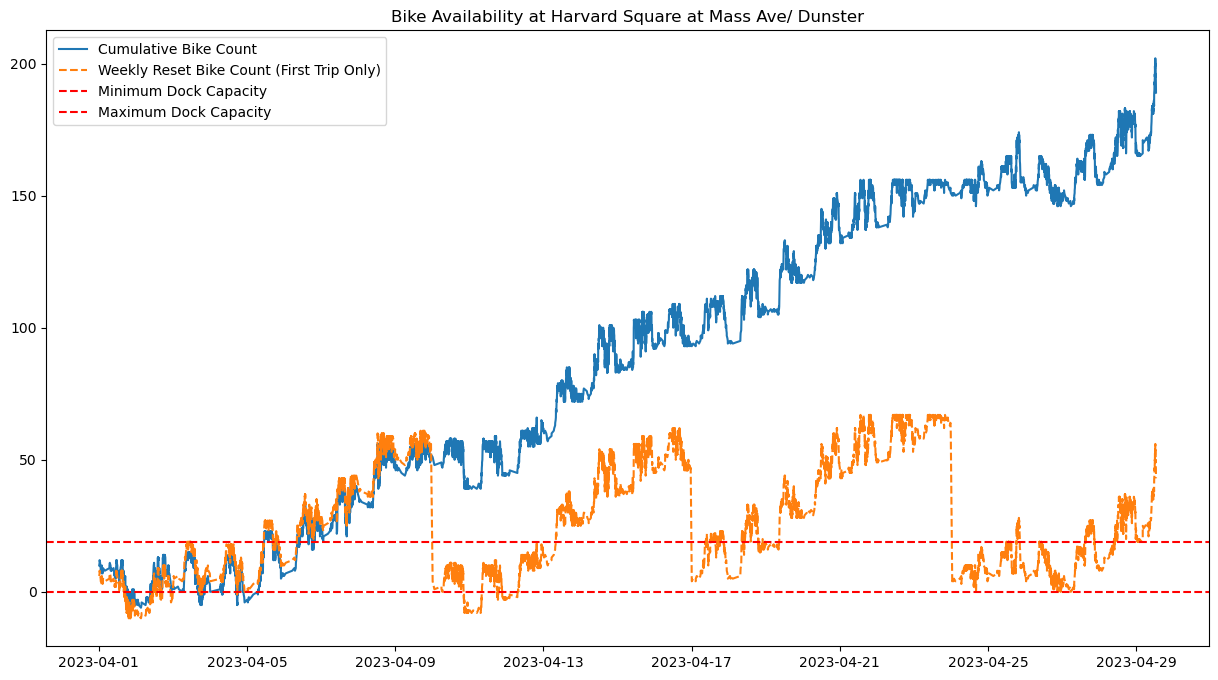

Unnamed: 0           ride_id rideable_type          started_at  \
0         280522  C3E61F51765EC1BF   docked_bike 2023-04-01 00:14:10   
1         280301  3BC255EB1E131D87   docked_bike 2023-04-01 00:10:15   
2         280348  4C8D1484E18AFA67   docked_bike 2023-04-01 00:06:15   
3         209450  E38DD9BFA1F006FA   docked_bike 2023-04-01 00:56:39   
4         292997  B73940BD8E2FA1B2   docked_bike 2023-04-01 01:01:52   
...          ...               ...           ...                 ...   
9995      233879  1535CCC846B9CCC9   docked_bike 2023-04-29 12:48:52   
9996      203215  32D551D32D3F706B   docked_bike 2023-04-29 12:49:20   
9997      238460  DD1FB5EF971CFCCD   docked_bike 2023-04-29 12:51:26   
9998      120222  084F23641EA32BB2   docked_bike 2023-04-29 12:38:19   
9999      108092  7ADDBAE84312BA6F   docked_bike 2023-04-29 12:52:13   

                ended_at                   start_station_name  \
0    2023-04-01 00:20:19   Beacon St at Washington / Kirkland   
1    2023-04-01 00:36:09            Tremont St at Hamilton Pl   
2    2023-04-01 00:36:18            Tremont St at Hamilton Pl   
3    2023-04-01 01:04:17  Harvard Square at Mass Ave/ Dunster   
4    2023-04-01 01:09:11  Harvard Square at Mass Ave/ Dunster   
...                  ...                                  ...   
9995 2023-04-29 13:19:44  Harvard Square at Mass Ave/ Dunster   
9996 2023-04-29 12:53:19  Harvard Square at Mass Ave/ Dunster   
9997 2023-04-29 13:02:14  Harvard Square at Mass Ave/ Dunster   
9998 2023-04-29 12:52:03        Gore Street at Lambert Street   
9999 2023-04-29 12:59:02  Harvard Square at Mass Ave/ Dunster   

     start_station_id                                   end_station_name  \
0              S32003                Harvard Square at Mass Ave/ Dunster   
1              B32056                Harvard Square at Mass Ave/ Dunster   
2              B32056                Harvard Square at Mass Ave/ Dunster   
3              M32018  Graham and Parks School – Linnaean St at Walke...   
4              M32018                                      191 Beacon St   
...               ...                                                ...   
9995           M32018                                     Kenmore Square   
9996           M32018  Harvard University Radcliffe Quadrangle at She...   
9997           M32018                           Huron Ave At Vassal Lane   
9998           M32081                Harvard Square at Mass Ave/ Dunster   
9999           M32018  Harvard University Radcliffe Quadrangle at She...   

     end_station_id  start_lat  ...    end_lat    end_lng  member_casual  \
0            M32018  42.378754  ...  42.373268 -71.118579         casual   
1            M32018  42.356683  ...  42.373268 -71.118579         casual   
2            M32018  42.356683  ...  42.373268 -71.118579         casual   
3            M32068  42.373268  ...  42.382944 -71.124498         member   
4            S32035  42.373268  ...  42.380323 -71.108786         member   
...             ...        ...  ...        ...        ...            ...   
9995         B32010  42.373268  ...  42.348706 -71.097009         casual   
9996         M32024  42.373268  ...  42.380287 -71.125107         member   
9997         M32044  42.373268  ...  42.381651 -71.134270         member   
9998         M32018  42.373080  ...  42.373268 -71.118579         member   
9999         M32024  42.373268  ...  42.380287 -71.125107         member   

     start_distance  end_distance                time bikechange  num_bikes  \
0      5.412947e-07  0.000000e+00 2023-04-01 00:20:19          1         10   
1      5.780138e-07  0.000000e+00 2023-04-01 00:36:09          1         11   
2      5.780138e-07  0.000000e+00 2023-04-01 00:36:18          1         12   
3      0.000000e+00  4.313931e-07 2023-04-01 00:56:39         -1         11   
4      0.000000e+00  3.733631e-07 2023-04-01 01:01:52         -1         10   
...             ...           ...                 ...       

In [3]:
# Define a function to plot cumulative activities of a station with and without weekly rebalancing

def station_activity_with_reset(n, start=0, end=-1, plotting=True, reset_value=None):
    origin = origins[n]
    destination = destinations[n]
    name = stations.NAME[n]

    # Process start and end station matches
    start_match = origin[origin['start_station_name'] == name].copy()
    start_match['time'] = start_match['started_at']
    start_match['bikechange'] = -1

    end_match = destination[destination['end_station_name'] == name].copy()
    end_match['time'] = end_match['ended_at']
    end_match['bikechange'] = +1

    # Combine and sort
    combined = pd.concat([start_match, end_match], ignore_index=True)
    combined = combined.sort_values('time').reset_index(drop=True)[start:end]
    combined['num_bikes'] = np.cumsum(combined['bikechange']) + stations['Total Docks'][n] // 2

    # Add weekday column
    combined['weekday'] = combined['time'].dt.weekday  # Get the day of the week (0=Monday, ..., 6=Sunday)

    # Reset the bike count only for the first trip on each Monday
    num_bikes_weekly = []
    if reset_value == None:
        reset_value = stations['Total Docks'][n] // 2  # Reset to half the total docks
    current_bike_count = reset_value
    last_weekday = None  # To track when Monday starts for the first trip

    for i, row in combined.iterrows():
        if row['weekday'] == 0 and row['weekday'] != last_weekday:  # First trip on Monday
            current_bike_count = reset_value
        current_bike_count += row['bikechange']
        num_bikes_weekly.append(current_bike_count)
        last_weekday = row['weekday']  # Update the last seen weekday

    combined['num_bikes_weekly'] = num_bikes_weekly

    # Plot if required
    if plotting:
        fig, ax = plt.subplots(figsize=(15, 8))
        plt.plot(combined['time'].values, combined['num_bikes'].values, label='Cumulative Bike Count')
        plt.plot(combined['time'].values, combined['num_bikes_weekly'].values, label='Weekly Reset Bike Count (First Trip Only)', linestyle='--')
        ax.axhline(y=0, color='red', linestyle='--', label='Minimum Dock Capacity')
        ax.axhline(y=stations['Total Docks'][n], color='red', linestyle='--', label='Maximum Dock Capacity')
        plt.title(f'Bike Availability at {name}')
        plt.legend()
        plt.show()

    return combined

# Test the function on random samples and a specific station
for i in random.sample(range(0, len(origins)), 5):
    station_activity_with_reset(i, start=0, end=700)

station_activity_with_reset(228, 0, 10000, reset_value = 5)


In [4]:
# Define a function that only keeps the weekdays
def weekdays(n):
    data = station_activity_with_reset(n, plotting=False)
    data = data[data.weekday.isin(range(5))]
    data = data.reset_index(drop=True)
    return data

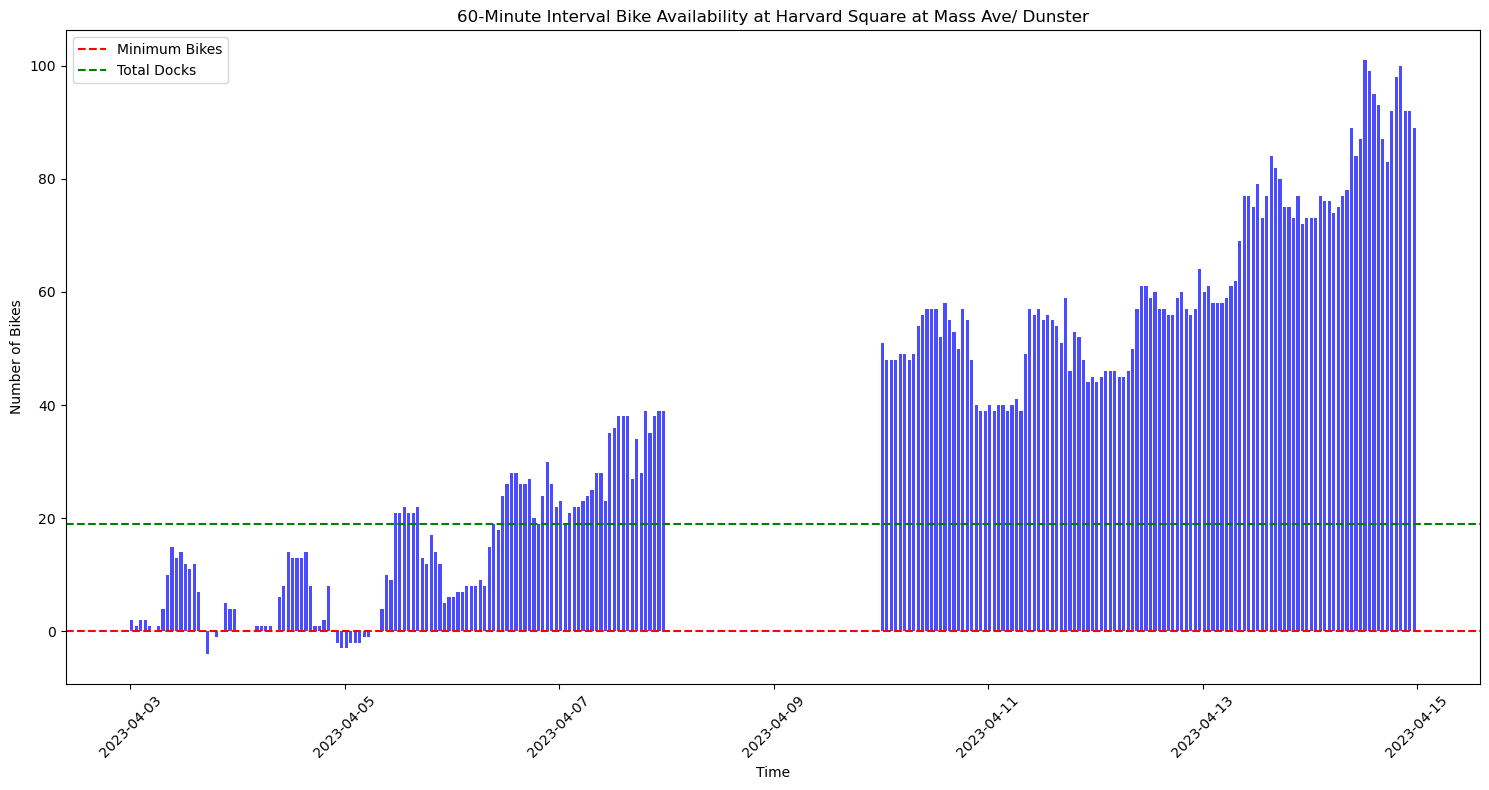

-4 101


In [5]:
# Define a function to report the bike availability in time intervals of e.g. 30 mins

def datetime_range(start, end, delta=dt.timedelta(minutes=60)):
    current = start
    while current <= end:  # Include the end time as well
        yield current
        current += delta

def find_closest(arr, target):
    idx = bisect.bisect_left(arr, target)

    # Adjust for bounds
    if idx == 0:
        return 0
    if idx == len(arr):
        return idx - 1

    # Find the closest value
    return idx if abs(arr[idx] - target) < abs(arr[idx - 1] - target) else idx - 1

def bikes_intervals(n, pstart=0, pend=500, reset_weekly = True, interval = 30):
    # Generate station activity data
    data = station_activity_with_reset(n, pstart, pend, plotting=False)
    
    # Ensure time is sorted for bisect
    data = data.sort_values('time').reset_index(drop=True)
    
    # Set up the 30-minute intervals
    start = data['time'].min()
    end = data['time'].max()
    intervals = list(datetime_range(start, end, ))
    
    # Map time intervals to bike counts
    bikes = []
    for T in intervals:
        idx = find_closest(data['time'], T)
        if reset_weekly:
            bikes.append(data.loc[idx, 'num_bikes_weekly'])
        else:
            bikes.append(data.loc[idx, 'num_bikes'])
    
    # Create the DataFrame
    df = pd.DataFrame({
        'time': intervals,
        'bikes': bikes
    })
    # remove weekends
    df = df[df.time.dt.weekday.isin(range(5))]
    df = df.reset_index(drop=True)

    # Plot the bar chart
    plt.figure(figsize=(15, 8))
    plt.bar(df['time'], df['bikes'], width=0.03, color='blue', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', label='Minimum Bikes')
    plt.axhline(y=stations['Total Docks'][n], color='green', linestyle='--', label='Total Docks')
    plt.xlabel('Time')
    plt.ylabel('Number of Bikes')
    plt.title(f'60-Minute Interval Bike Availability at {stations.NAME[n]}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return df

# Example usage
data = bikes_intervals(228, pstart=0, pend=5000, reset_weekly=False)
print(np.min(data.bikes), np.max(data.bikes))

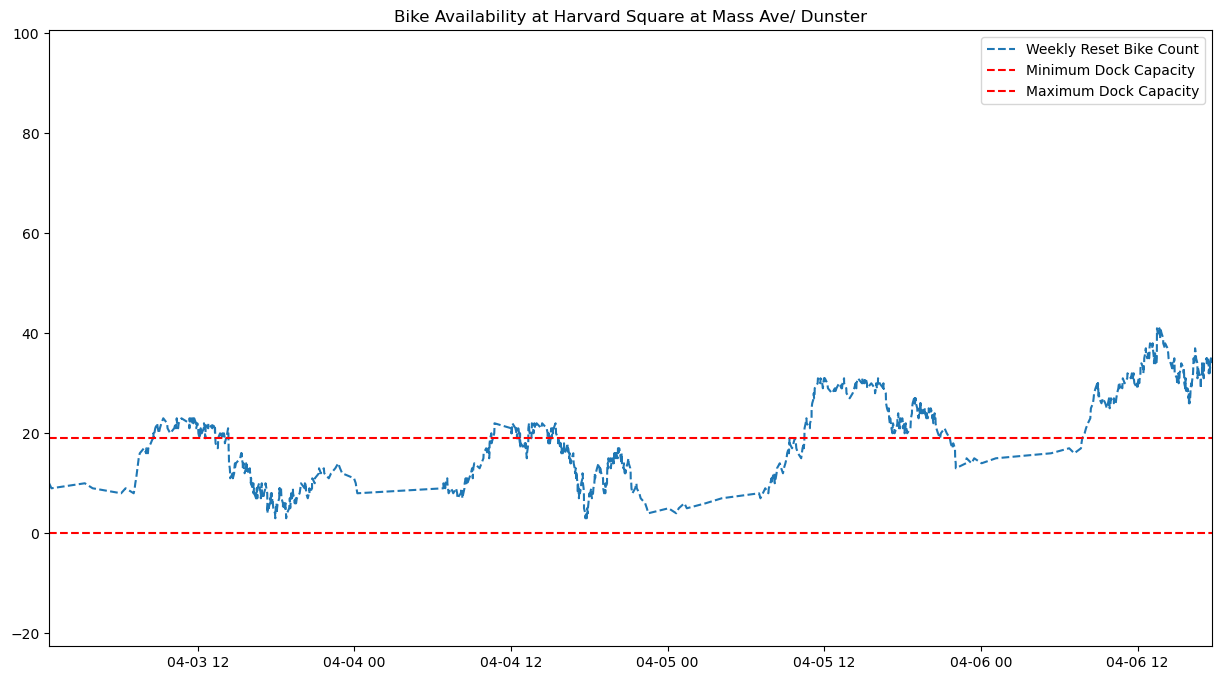

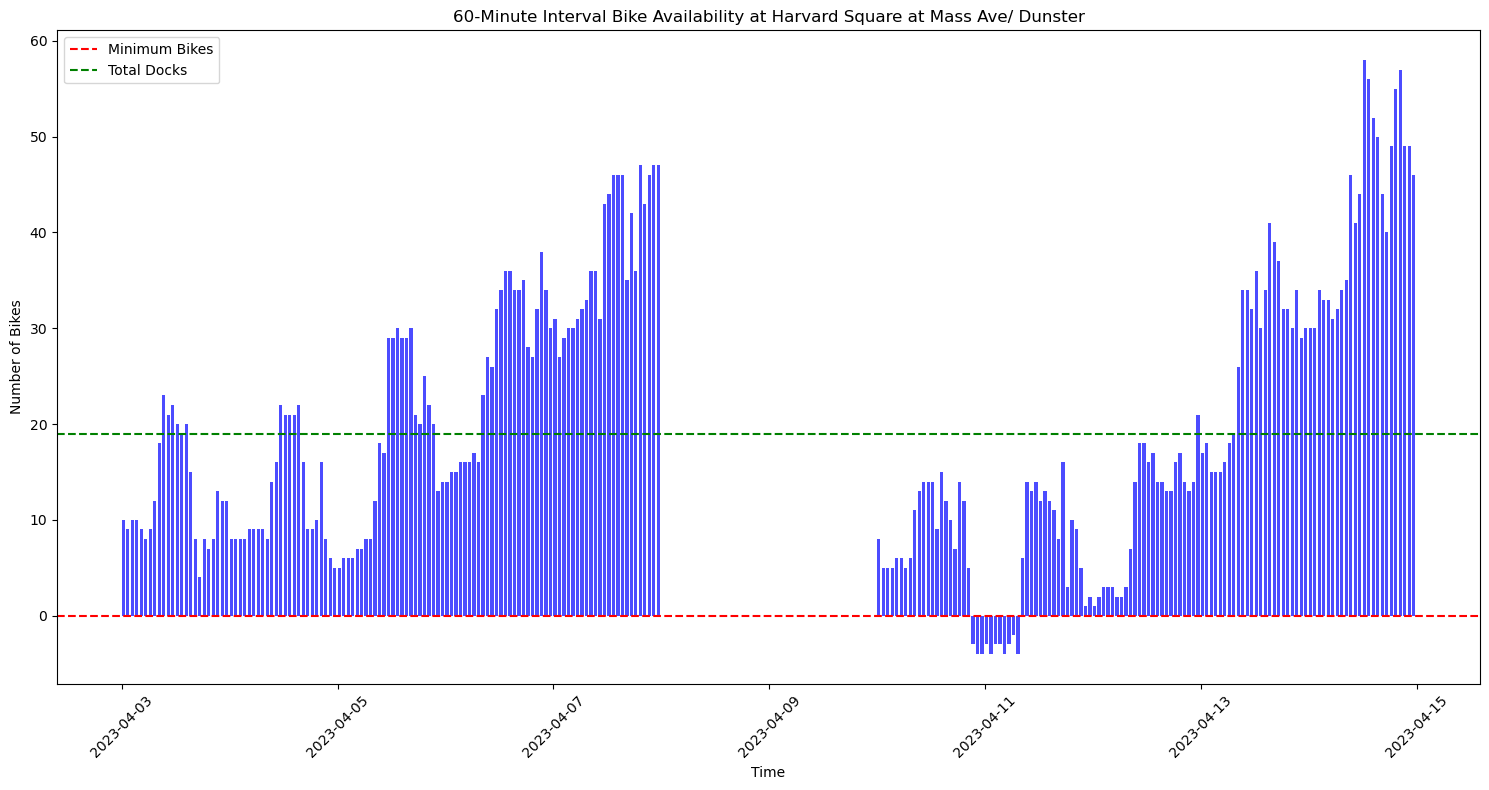

time  bikes
0   2023-04-03 00:20:19     10
1   2023-04-03 01:20:19      9
2   2023-04-03 02:20:19     10
3   2023-04-03 03:20:19     10
4   2023-04-03 04:20:19      9
..                  ...    ...
235 2023-04-14 19:20:19     55
236 2023-04-14 20:20:19     57
237 2023-04-14 21:20:19     49
238 2023-04-14 22:20:19     49
239 2023-04-14 23:20:19     46

[240 rows x 2 columns]

In [6]:
data = weekdays(228)
fig, ax = plt.subplots(figsize=(15, 8))
# plt.plot(data['time'], data['num_bikes'], label='Cumulative Bike Count')
plt.plot(data['time'].values, data['num_bikes_weekly'].values, label='Weekly Reset Bike Count', linestyle='--')
ax.axhline(y=0, color='red', linestyle='--', label='Minimum Dock Capacity')
ax.axhline(y=stations['Total Docks'][228], color='red', linestyle='--', label='Maximum Dock Capacity')
plt.xlim(data.time[0], data.time[1000])
plt.title(f'Bike Availability at {stations.NAME[228]}')
plt.legend()
plt.show()

bikes_intervals(228, pstart=0, pend=5000, reset_weekly=True)

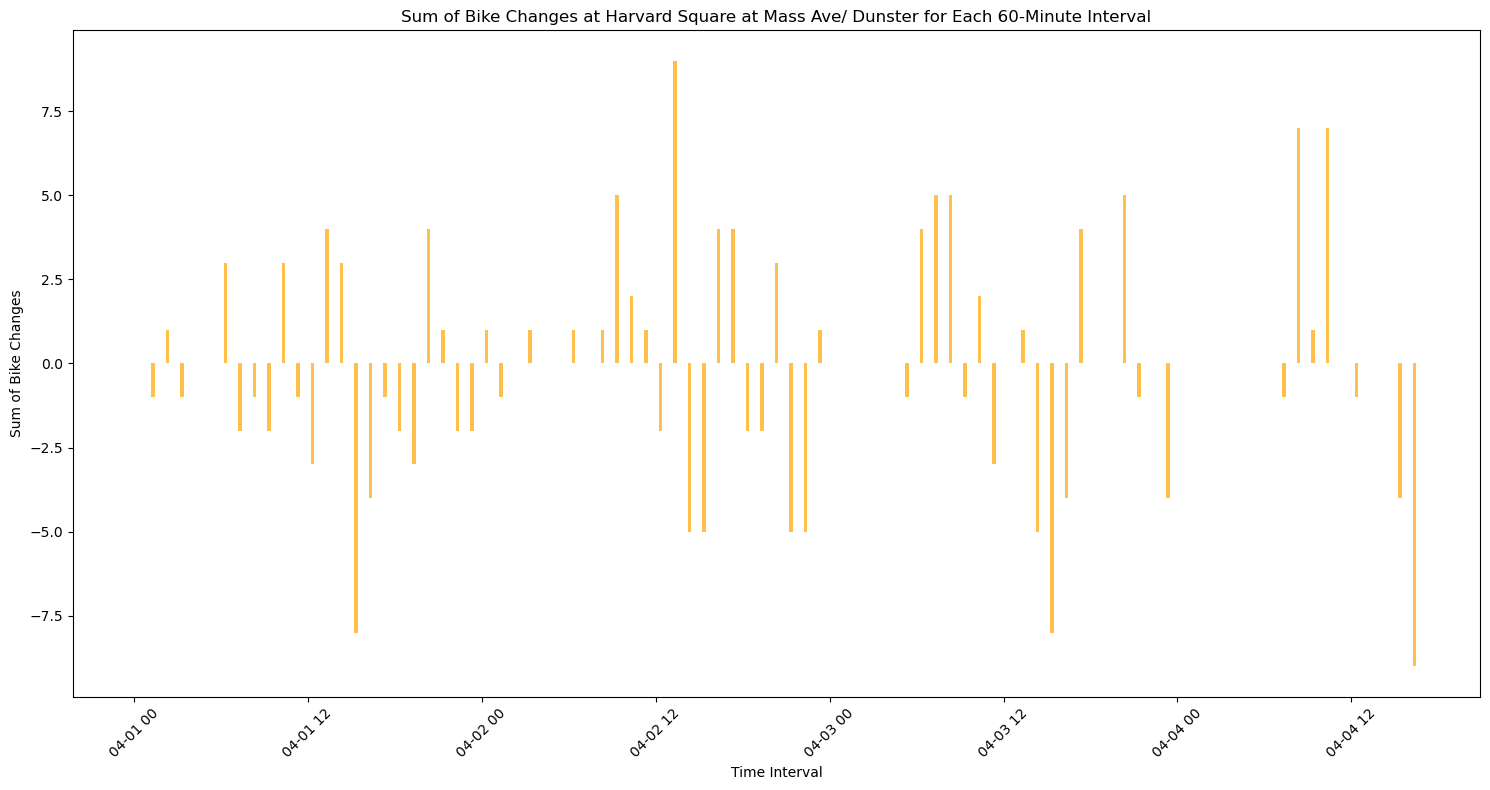

time_interval  sum_bikechange
0  2023-04-01 00:20:19               0
1  2023-04-01 01:20:19              -1
2  2023-04-01 02:20:19               1
3  2023-04-01 03:20:19              -1
4  2023-04-01 04:20:19               0
..                 ...             ...
84 2023-04-04 12:20:19              -1
85 2023-04-04 13:20:19               0
86 2023-04-04 14:20:19               0
87 2023-04-04 15:20:19              -4
88 2023-04-04 16:20:19              -9

[89 rows x 2 columns]

In [7]:
def bikes_and_changes_intervals(n, pstart=0, pend=500, interval=60):
    # Generate station activity data
    data = station_activity_with_reset(n, pstart, pend, plotting=False)
    
    # Ensure the 'time' column is sorted
    data = data.sort_values('time').reset_index(drop=True)
    
    # Create 30-minute intervals
    start = data['time'].min()
    end = data['time'].max()
    intervals = pd.date_range(start=start, end=end, freq=f'{interval}min')
    
    # Assign each row to a time interval
    data['time_interval'] = pd.cut(
        data['time'], bins=intervals, right=False, labels=intervals[:-1]
    )
    
    # Aggregate the data: sum of bikechange and the last known num_bikes
    bikechange_summary = data.groupby('time_interval')['bikechange'].sum().reset_index()
    bikechange_summary.rename(columns={'bikechange': 'sum_bikechange'}, inplace=True)
    
    # Plot the bar chart for bike changes
    plt.figure(figsize=(15, 8))
    plt.bar(bikechange_summary['time_interval'], bikechange_summary['sum_bikechange'], color='orange', alpha=0.7, width=0.01)
#     plt.axhline(y=-stations['Total Docks'][n], color='red', linestyle='--', label='Minimum Bikes')
#     plt.axhline(y=stations['Total Docks'][n], color='green', linestyle='--', label='Total Docks')
    plt.xlabel('Time Interval')
    plt.ylabel('Sum of Bike Changes')
    plt.title(f'Sum of Bike Changes at {stations.NAME[n]} for Each {interval}-Minute Interval')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return bikechange_summary

# Example usage
bikes_and_changes_intervals(228, 0, 1000)


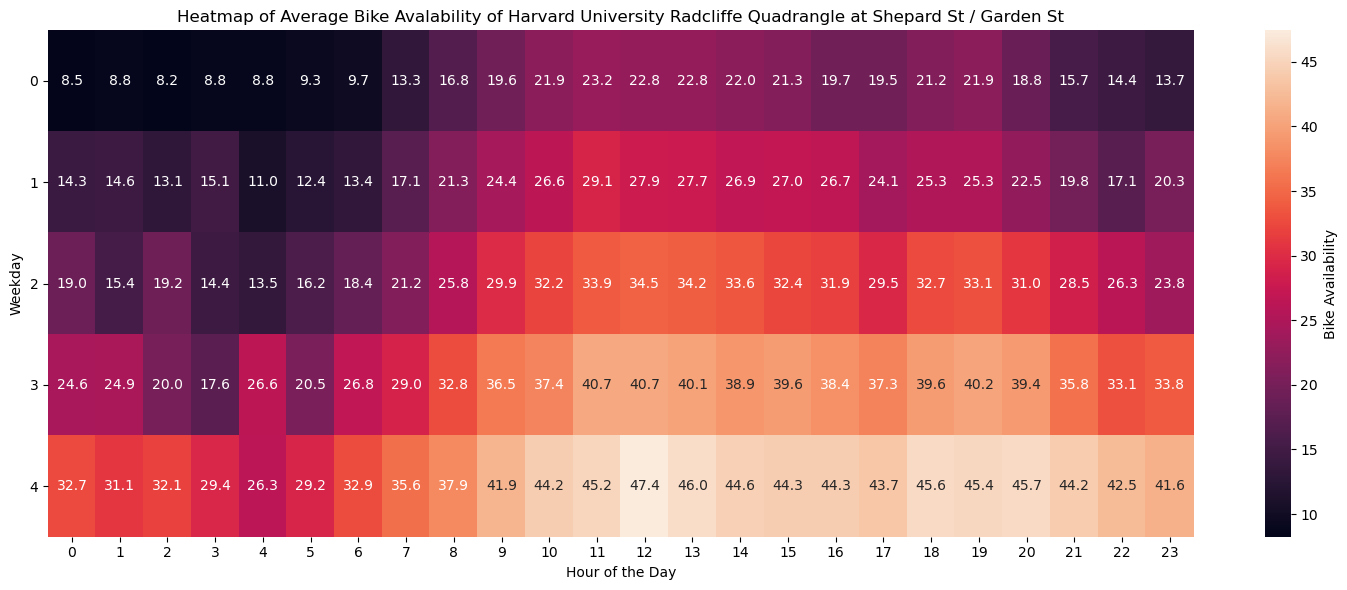

In [8]:
# sketch the heatmap of average hourly bikes of a station during weekdays
def station_heatmap(data):
    data['hour'] = data.time.dt.hour
    
    pattern = data.groupby(['weekday', 'hour']).agg({'num_bikes_weekly': 'mean'}) # returns the average number of bikes in a station during a specific hour of a week with weekly rebalancing

    heatmap_data = pattern.pivot_table(index="weekday", columns="hour", values="num_bikes_weekly", fill_value=0)

    # Step 2: Plot the heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cbar_kws={'label': 'Bike Availability'})

    # Step 3: Customize the plot
    plt.title(f"Heatmap of Average Bike Avalability of {data.start_station_name[0]}")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Weekday")
    plt.yticks(rotation=0)  # Keep weekday labels horizontal

    # Show the heatmap
    plt.tight_layout()
    plt.show()

# for i in range(len(origins)-400):
#     station_heatmap(i)
station_heatmap(weekdays(228))

In [9]:
# record the average hourly bike availability of each week in a 3d matrix for rach station

def station_3d_matrix(data, plotting = False):
    # Add the 'week' column for grouping by week number
    data['week'] = data['time'].dt.isocalendar().week
    data['year'] = data['time'].dt.year  # To handle weeks across multiple years
    max_weekday = 4  # Weekdays (0 to 4)
    max_hour = 23
    heatmap_list = []
    # Group by year and week
    weekly_groups = data.groupby(['year', 'week'])

    for (year, week), week_data in weekly_groups:
        # Extract the week-specific data
        week_data = week_data.copy()
        week_data['hour'] = week_data['time'].dt.hour

        # Aggregate the data for the heatmap
        pattern = week_data.groupby(['weekday', 'hour']).agg({'num_bikes_weekly': 'mean'})

        # Create the pivot table
        heatmap_data = pattern.pivot_table(index="weekday", columns="hour", values="num_bikes_weekly")

        # Reindex to ensure a 5x24 matrix for weekdays (0-4) and hours (0-23)
        heatmap_data = heatmap_data.reindex(index=range(5), columns=range(24))  # Ensures 5 weekdays and 24 hours

        # Interpolate missing data along both axes (linear interpolation)
        heatmap_data = heatmap_data.interpolate(method='linear', axis=1)  # Interpolate along hours
        heatmap_data = heatmap_data.interpolate(method='linear', axis=0)  # Interpolate along weekdays

        # Handle wraparound from hour 23 to 0 correctly (previous day's hour 23 for the first hour of the next day)
        for weekday in range(5):
            if pd.isna(heatmap_data.at[weekday, 0]):
                heatmap_data.at[weekday, 0] = heatmap_data.at[(weekday - 1) % 5, 23]

        # Check if still any NaN values exist, fill them with nearest values
        heatmap_data = heatmap_data.fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)
        heatmap_data = heatmap_data.fillna(method='bfill', axis=0).fillna(method='ffill', axis=0)

        # Ensure the final heatmap is always a 5x24 matrix
        assert heatmap_data.shape == (5, 24), f"Expected 5x24 matrix, but got {heatmap_data.shape}"

        if plotting:
        # Plot the heatmap
            plt.figure(figsize=(15, 6))
            sns.heatmap(heatmap_data, annot=True, fmt=".0f", cbar_kws={'label': 'Bike Availability'})

            # Customize the plot
            plt.title(f"Heatmap of Bike Availability: Week {week}, {year}")
            plt.xlabel("Hour of the Day")
            plt.ylabel("Weekday")
            plt.yticks(rotation=0)  # Keep weekday labels horizontal

            # Show the heatmap
            plt.tight_layout()
            plt.show()
        
        heatmap_array = np.zeros((max_weekday + 1, max_hour + 1))  # 5x24
        for weekday, hour_data in heatmap_data.iterrows():
            for hour, value in hour_data.items():
                heatmap_array[int(weekday), int(hour)] = value

        # Append the 2D heatmap to the list
        heatmap_list.append(heatmap_array)

    # Stack all 2D heatmaps into a 3D matrix (weeks x weekdays x hours)
    heatmap_3d_matrix = np.stack(heatmap_list, axis=0)

    return heatmap_3d_matrix, data.time.iloc[0], data.time.iloc[-1]

# Example usage
heatmap_matrix, start, end = station_3d_matrix(weekdays(4))
print(start, end)
print(f"Station: {stations.NAME[4]}")
print(f"3D Heatmap Matrix Shape: {heatmap_matrix.shape}")
print(f"Weekly Heatmap (First Week): \n{heatmap_matrix[0]}")
heatmap_matrix.shape

station_3d_matrix(weekdays(228))[0][0]

2023-04-13 15:23:17 2024-10-31 08:40:13.465000
Station: 2 Hummingbird Lane at Olmsted Green
3D Heatmap Matrix Shape: (70, 5, 24)
Weekly Heatmap (First Week): 
[[6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
 [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 6. 6. 6. 6. 6. 6. 6.]]


array([[ 9.5       ,  9.5       ,  9.5       ,  9.5       ,  9.16666667,
         8.83333333,  8.5       , 12.5       , 18.83333333, 21.28571429,
        21.88888889, 22.15384615, 20.61111111, 19.625     , 15.5       ,
        13.68421053,  8.87096774,  6.32258065,  6.11538462,  7.14285714,
         9.2       , 12.4       , 12.6       , 11.5       ],
       [ 9.        ,  9.08333333,  9.16666667,  9.25      ,  9.33333333,
         9.41666667,  9.5       ,  8.77777778,  9.53846154, 13.3       ,
        18.125     , 18.9375    , 19.75      , 19.26923077, 19.5       ,
        19.04545455, 15.16      ,  7.72222222, 10.36842105, 12.5       ,
        14.68      , 10.        ,  5.        ,  5.        ],
       [ 4.66666667,  5.5       ,  6.        ,  6.5       ,  7.        ,
         7.5       ,  8.        ,  8.85714286, 11.78571429, 17.        ,
        19.35714286, 28.17647059, 29.25      , 29.3       , 29.77777778,
        29.7       , 27.33333333, 21.86363636, 23.5       , 24.5       ,
  

# Weather Data

In [10]:
# Prepare weather dataset

def cleaning(data):
    # Convert 'DATE' column to datetime
    data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

    # Extract the hour from the 'DATE' column
    data['hour'] = data['DATE'].dt.hour
    data['date'] = data['DATE'].dt.date

    # Aggregate by hour and calculate the mean for temperature, wind_speed, and precipitation
    weather = data.groupby(['date', 'hour']).agg({
        'temperature': 'mean',
        'wind_speed': 'mean',
        'precipitation': 'mean'
    }).reset_index()

    return pd.DataFrame(weather)

weather = pd.concat([cleaning(pd.read_csv('Hourly2023.csv')), cleaning(pd.read_csv('Hourly2024.csv'))], ignore_index=True)
weather

/tmp/ipykernel_71890/4252785299.py:20: DtypeWarning: Columns (32,56,62,72,73,75,77,78,79,81,83,96,97,99,101,114,115,117,119) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.concat([cleaning(pd.read_csv('Hourly2023.csv')), cleaning(pd.read_csv('Hourly2024.csv'))], ignore_index=True)


date  hour  temperature  wind_speed  precipitation
0      2023-01-01     0    11.300000    3.266667           0.25
1      2023-01-01     1    11.400000    3.600000           0.35
2      2023-01-01     2    11.100000    3.100000           1.80
3      2023-01-01     3    11.066667    3.100000           2.30
4      2023-01-01     4    12.200000    4.350000           1.10
...           ...   ...          ...         ...            ...
16795  2024-12-01    19          NaN         NaN            NaN
16796  2024-12-01    20          NaN         NaN            NaN
16797  2024-12-01    21          NaN         NaN            NaN
16798  2024-12-01    22          NaN         NaN            NaN
16799  2024-12-01    23          NaN         NaN            NaN

[16800 rows x 5 columns]

In [11]:
station_matrix, start, end = station_3d_matrix(weekdays(228))
start_date = start.to_pydatetime().date()
start_hour = start.hour
end_date = end.to_pydatetime().date()
end_hour = end.hour

filtered_weather = weather[
    ((weather['date'] >= start_date) &
    (weather['date'] <= end_date))
]
filtered_weather.reset_index(drop=True)

date  hour  temperature  wind_speed  precipitation
0      2023-04-03     0          4.7         5.9            0.0
1      2023-04-03     1          3.3         4.1            0.0
2      2023-04-03     2          2.8         4.6            0.0
3      2023-04-03     3          2.5         4.6            0.0
4      2023-04-03     4          1.7         5.1            0.0
...           ...   ...          ...         ...            ...
13843  2024-10-31    19         76.6         8.9            0.0
13844  2024-10-31    20         75.1         9.2            0.0
13845  2024-10-31    21         71.7         9.7            0.0
13846  2024-10-31    22         68.1        11.3            0.0
13847  2024-10-31    23         68.3        13.0            0.0

[13848 rows x 5 columns]

In [12]:
# Create 3D matrix for temperature
def weather_3d_matrix(data, variable='temperature', plotting=False):
    # Ensure a copy of the DataFrame is used to avoid SettingWithCopyWarning
    data = data.copy()
    
    # Convert 'date' column to datetime
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    
    # Add 'weekday' column
    data['weekday'] = data['date'].dt.weekday
    
    # Filter to keep only weekdays and reset the index
    data = data[data['weekday'].isin(range(5))].reset_index(drop=True)
    
    # Add 'week' and 'year' columns for grouping
    data['week'] = data['date'].dt.isocalendar().week
    data['year'] = data['date'].dt.year
    
    # Interpolate missing values in the variable column
    data[variable] = data[variable].interpolate()
    
    max_weekday = 4  # Weekdays (0 to 4)
    max_hour = 23
    heatmap_list = []
    
    # Group by year and week
    weekly_groups = data.groupby(['year', 'week'])

    for (year, week), week_data in weekly_groups:
        week_data = week_data.copy()

        # Aggregate and pivot to create the heatmap
        pattern = week_data.groupby(['weekday', 'hour']).agg({variable: 'mean'})
        heatmap_data = pattern.pivot_table(index="weekday", columns="hour", values=variable)
        
        # Fill any remaining NaN values in the heatmap with interpolation across the grid
        heatmap_data = heatmap_data.apply(lambda x: x.interpolate(method='linear', axis=0), axis=1).fillna(method='bfill').fillna(method='ffill')
        
        if plotting:
            # Plot the heatmap
            plt.figure(figsize=(15, 6))
            sns.heatmap(heatmap_data, annot=True, fmt=".0f", cbar_kws={'label': f'{variable}'})
            plt.title(f"Heatmap of {variable}: Week {week}, {year}")
            plt.xlabel("Hour of the Day")
            plt.ylabel("Weekday")
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        
        heatmap_array = np.zeros((max_weekday + 1, max_hour + 1))
        for weekday, hour_data in heatmap_data.iterrows():
            for hour, value in hour_data.items():
                heatmap_array[int(weekday), int(hour)] = value
        
        heatmap_list.append(heatmap_array)
    
    heatmap_3d_matrix = np.stack(heatmap_list, axis=0)
    return heatmap_3d_matrix

# Example of usage:
temperature_matrix = weather_3d_matrix(filtered_weather, variable='temperature')
wind_matrix = weather_3d_matrix(filtered_weather, variable='wind_speed')
precipitation_matrix = weather_3d_matrix(filtered_weather, variable='precipitation')
wind_matrix.shape


(83, 5, 24)

In [13]:


# Reshape matrices for ease of handling
num_weeks, num_days, num_hours = station_matrix.shape
start_week = start_date.isocalendar()[1]
start_weekday = start_date.isocalendar()[2]-1
features = []

# Flatten and combine features
for week in range(num_weeks):
    for day in range(num_days):
        for hour in range(num_hours):
            features.append([
                (week+start_week) % 52,  # Week of the year
                (day+start_weekday)%5,        # Day of the week
                (hour+start_hour)%24,       # Hour of the day
                temperature_matrix[week, day, hour],
                wind_matrix[week, day, hour],
                precipitation_matrix[week, day, hour],
            ])

features = np.array(features)
targets = station_matrix.flatten()

# Normalize data
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
targets = targets.reshape(-1, 1)
targets = scaler.fit_transform(targets)

# Reshape for sequential model
sequence_length = 24  # Using the last 24 hours to predict the next value
X, y = [], []

for i in range(len(features) - sequence_length):
    X.append(features[i:i+sequence_length])
    y.append(targets[i+sequence_length])

X = np.array(X)
y = np.array(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, X.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)


Epoch 1/20
249/249 [==============================] - 4s 12ms/step - loss: 0.0190 - mae: 0.1030 - val_loss: 0.0129 - val_mae: 0.0866
Epoch 2/20
249/249 [==============================] - 3s 11ms/step - loss: 0.0128 - mae: 0.0852 - val_loss: 0.0125 - val_mae: 0.0840
Epoch 3/20
249/249 [==============================] - 3s 11ms/step - loss: 0.0125 - mae: 0.0841 - val_loss: 0.0116 - val_mae: 0.0810
Epoch 4/20
249/249 [==============================] - 3s 11ms/step - loss: 0.0123 - mae: 0.0828 - val_loss: 0.0120 - val_mae: 0.0820
Epoch 5/20
249/249 [==============================] - 3s 11ms/step - loss: 0.0119 - mae: 0.0814 - val_loss: 0.0112 - val_mae: 0.0791
Epoch 6/20
249/249 [==============================] - 3s 11ms/step - loss: 0.0117 - mae: 0.0803 - val_loss: 0.0109 - val_mae: 0.0783
Epoch 7/20
249/249 [==============================] - 3s 11ms/step - loss: 0.0114 - mae: 0.0795 - val_loss: 0.0106 - val_mae: 0.0764
Epoch 8/20
249/249 [==============================] - 3s 11ms/step - 

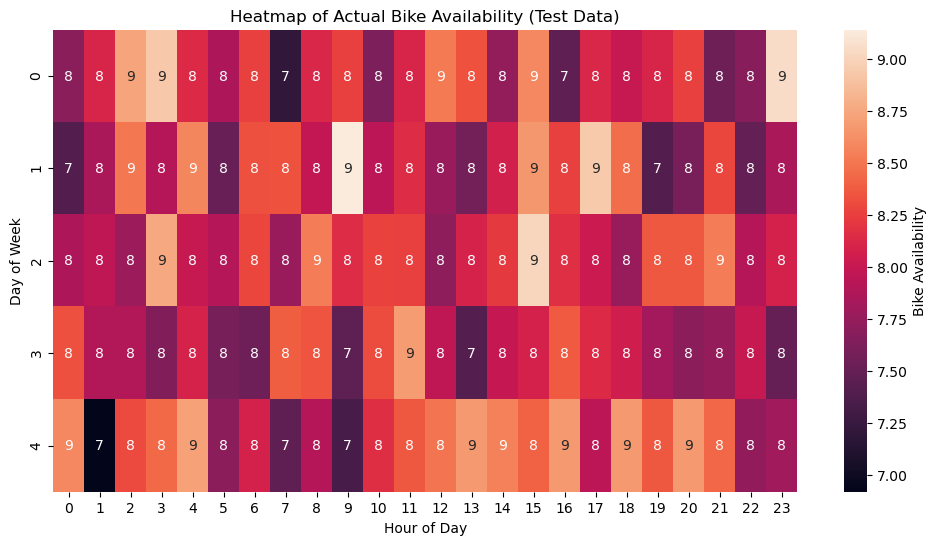

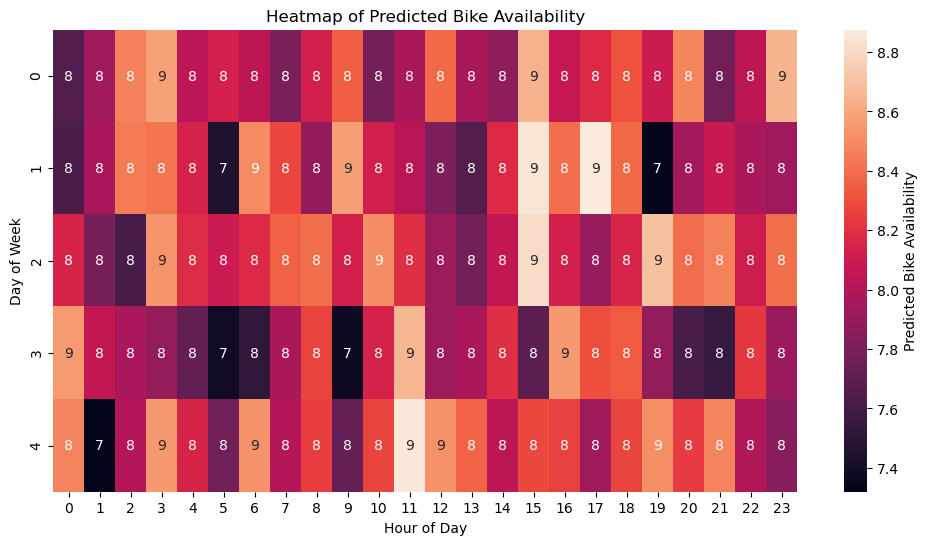

In [14]:
# Reshape test data and predictions for heatmap comparison
# Determine the number of weeks in the test set
num_weeks_test = y_test_original.shape[0] // (num_days * num_hours)

y_test_reshaped = y_test_original[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
predictions_reshaped = predictions[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)

# Generate heatmap for actual data
plt.figure(figsize=(12, 6))
sns.heatmap(np.mean(y_test_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': 'Bike Availability'})
plt.title('Heatmap of Actual Bike Availability (Test Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Generate heatmap for predicted data
plt.figure(figsize=(12, 6))
sns.heatmap(np.mean(predictions_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': 'Predicted Bike Availability'})
plt.title('Heatmap of Predicted Bike Availability')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


In [15]:
# Reshape test data and predictions for heatmap comparison
num_weeks_test = y_test_original.shape[0] // (num_days * num_hours)

y_test_reshaped = y_test_original[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
predictions_reshaped = predictions[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)

# Compute average across weeks for both actual and predicted data
actual_mean_per_hour = np.mean(y_test_reshaped, axis=0)
predicted_mean_per_hour = np.mean(predictions_reshaped, axis=0)

# Flatten the averaged data to calculate RMSE between heatmaps
actual_flattened = actual_mean_per_hour.flatten()
predicted_flattened = predicted_mean_per_hour.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_flattened, predicted_flattened))
print(f"RMSE between heatmaps: {rmse}")


RMSE between heatmaps: 0.2676243203850503


# Move all the prediction steps into a function to predict for all stations

In [13]:
def predict_station_demand(n, plotting=False):
    station_matrix, start, end = station_3d_matrix(weekdays(n))
    start_date = start.to_pydatetime().date()
    start_hour = start.hour
    end_date = end.to_pydatetime().date()
    end_hour = end.hour

    filtered_weather = weather[
        ((weather['date'] >= start_date) &
        (weather['date'] <= end_date))
    ]
    filtered_weather.reset_index(drop=True)

    temperature_matrix = weather_3d_matrix(filtered_weather, variable = 'temperature')
    wind_matrix = weather_3d_matrix(filtered_weather, variable = 'wind_speed')
    precipitation_matrix = weather_3d_matrix(filtered_weather, variable = 'precipitation')
    

    # Reshape matrices for ease of handling
    num_weeks, num_days, num_hours = station_matrix.shape
    start_week = start_date.isocalendar()[1]
    start_weekday = start_date.isocalendar()[2]-1
    features = []

    # Flatten and combine features
    for week in range(num_weeks):
        for day in range(num_days):
            for hour in range(num_hours):
                features.append([
                    (week+start_week) % 52,  # Week of the year
                    (day+start_weekday)%5,        # Day of the week
                    (hour+start_hour)%24,       # Hour of the day
                    temperature_matrix[week, day, hour],
                    wind_matrix[week, day, hour],
                    precipitation_matrix[week, day, hour],
                ])

    features = np.array(features)
    targets = station_matrix.flatten()

    # Normalize data
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    targets = targets.reshape(-1, 1)
    targets = scaler.fit_transform(targets)

    # Reshape for sequential model
    sequence_length = 24  # Using the last 24 hours to predict the next value
    X, y = [], []

    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(targets[i+sequence_length])

    X = np.array(X)
    y = np.array(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    # Build the LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, X.shape[2])),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Evaluate the model
    loss, mae = model.evaluate(X_test, y_test)
#     print(f"Test Loss: {loss}, Test MAE: {mae}")

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions to original scale
    predictions = scaler.inverse_transform(predictions)
    y_test_original = scaler.inverse_transform(y_test)
    num_weeks_test = y_test_original.shape[0] // (num_days * num_hours)

    y_test_reshaped = y_test_original[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
    predictions_reshaped = predictions[:num_weeks_test * num_days * num_hours].reshape(num_weeks_test, num_days, num_hours)
    if plotting:
        # Generate heatmap for actual data
        plt.figure(figsize=(12, 6))
        sns.heatmap(np.mean(y_test_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': f'Bike Availability'})
        plt.title(f'Heatmap of Actual Bike Availability  @ {stations.NAME[n]}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.show()

        # Generate heatmap for predicted data
        plt.figure(figsize=(12, 6))
        sns.heatmap(np.mean(predictions_reshaped, axis=0), annot=True, fmt=".0f", cbar_kws={'label': 'Predicted Bike Availability'})
        plt.title(f'Heatmap of Predicted Bike Availability @ {stations.NAME[n]}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Day of Week')
        plt.show()


    # Flatten the averaged data to calculate RMSE between heatmaps
    actual_flattened = y_test_reshaped.flatten()
    predicted_flattened = predictions_reshaped.flatten()
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual_flattened, predicted_flattened))
    print(n)
    return (rmse, y_test_reshaped, predictions_reshaped)

# predict_station_demand(228, plotting=True)

In [14]:
"""
from multiprocessing import Pool
if __name__ == '__main__':
    with Pool(processes=20) as pool:  # Adjust the number of processes as needed
        results = pool.map(predict_station_demand, range(len(stations)))
        """

"\nfrom multiprocessing import Pool\nif __name__ == '__main__':\n    with Pool(processes=20) as pool:  # Adjust the number of processes as needed\n        results = pool.map(predict_station_demand, range(len(stations)))\n        "

In [15]:
results = np.load('results.npy', allow_pickle=True)
RMSEs = []
for i in range(len(results)):
    RMSEs.append(results[i][0])
docks = stations['Total Docks']
respective_error = RMSEs/docks
flaw = np.mean(respective_error)
flaw

0.2878071982882402

In [16]:
to_remove = []
for i in range(len(stations)):
    if ((len(origins[i])<=100) or (len(destinations[i])<=100)):
        to_remove.append(i)
        

stations.drop(to_remove, inplace=True)
origins = np.delete(origins, to_remove, axis=0)
destinations = np.delete(destinations, to_remove, axis=0)

def index_finder(lst, source = stations.NAME):
    return [np.where(source== i)[0][0] for i in lst]
def popularity(i=5):
    sorted_origins = sorted(origins, key=len, reverse = True)
    popular_origins = [o.start_station_name[0] for o in sorted_origins[0:i]]
    unpopular_origins = [o.start_station_name[0] for o in sorted_origins[-(i+1):-1]]
    sorted_destinations = sorted(destinations, key=len, reverse = True)
    popular_destinations = [o.end_station_name[0] for o in sorted_destinations[0:i]]
    unpopular_destnations = [o.end_station_name[0] for o in sorted_destinations[-(i+1):-1]]
    
    for pop in [popular_origins, popular_destinations, unpopular_origins, unpopular_destnations]:
        print(pop)
    return index_finder(popular_origins), index_finder(popular_destinations), index_finder(unpopular_origins), index_finder(unpopular_destnations)

popular_origins, popular_destinations, unpopular_origins, unpopular_destnations = popularity()

/home/tabatabaeibalaei.f/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


['MIT at Mass Ave / Amherst St', 'Central Square at Mass Ave / Essex St', 'Harvard Square at Mass Ave/ Dunster', 'MIT Pacific St at Purrington St', 'Charles Circle - Charles St at Cambridge St']
['MIT at Mass Ave / Amherst St', 'Central Square at Mass Ave / Essex St', 'Harvard Square at Mass Ave/ Dunster', 'Ames St at Main St', 'Charles Circle - Charles St at Cambridge St']
['Hyde Park Library', 'American Legion Hwy at Hyde Park Ave', 'Cedar Grove T Stop', 'Cummins Highway at Blue Hill Ave T Stop', 'Community Life Center']
['Hyde Park Library', 'American Legion Hwy at Hyde Park Ave', 'Cedar Grove T Stop', 'Cummins Highway at Blue Hill Ave T Stop', 'Community Life Center']


/home/tabatabaeibalaei.f/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


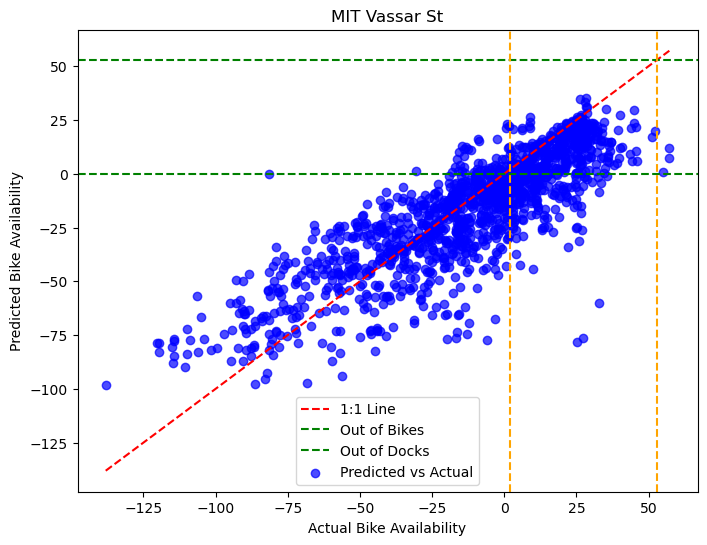

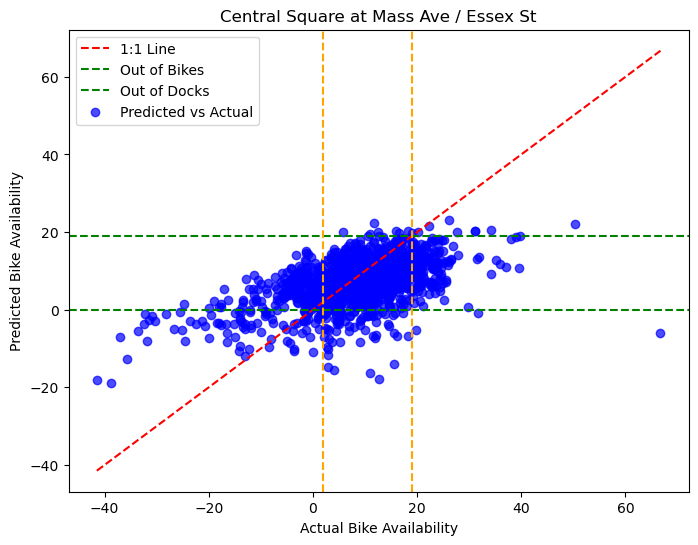

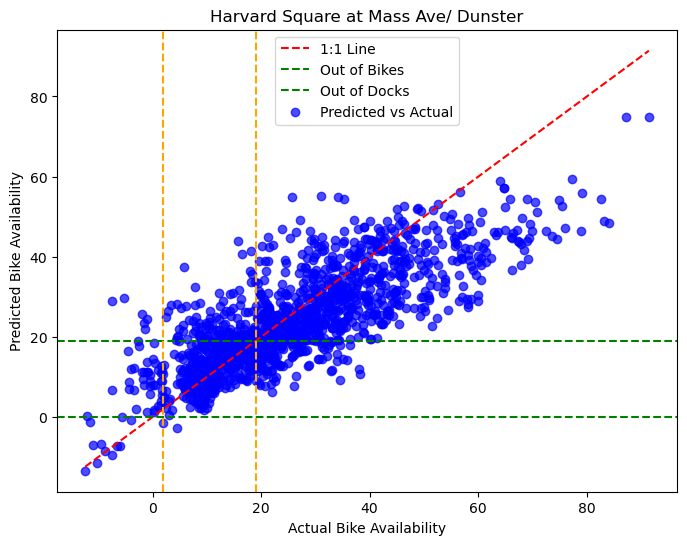

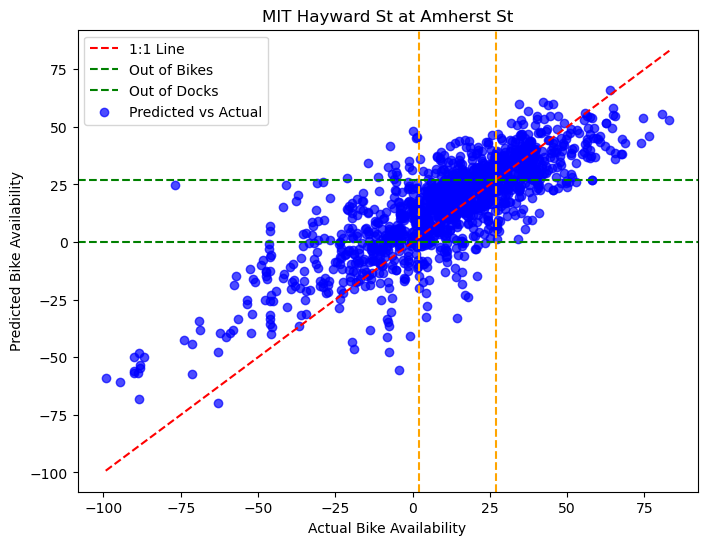

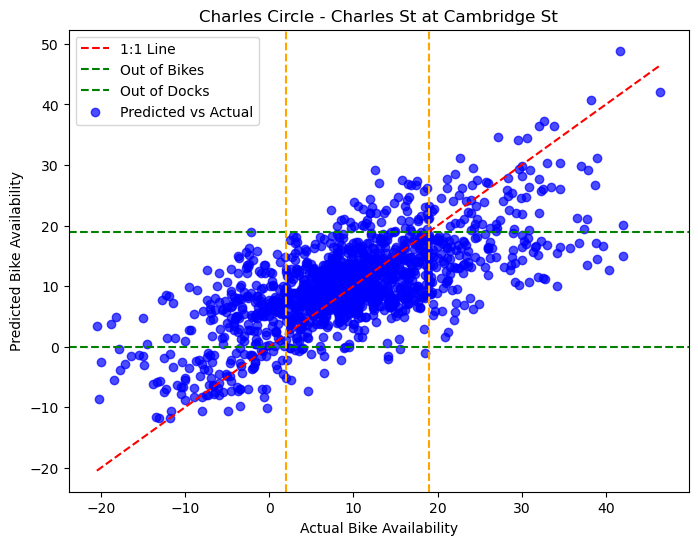

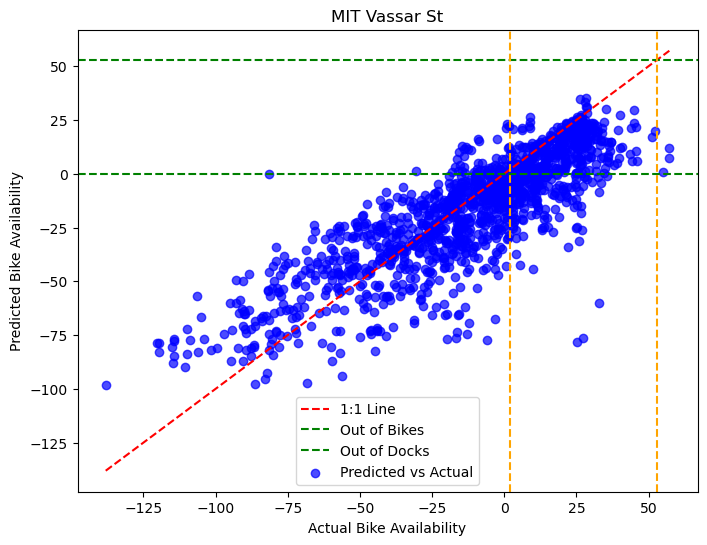

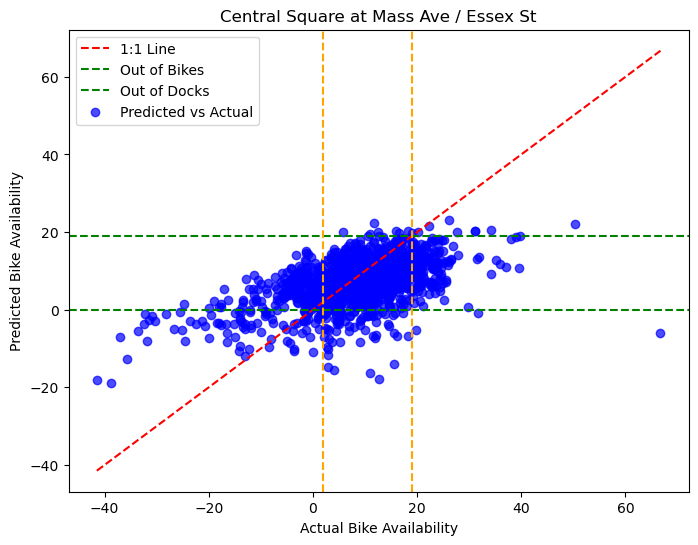

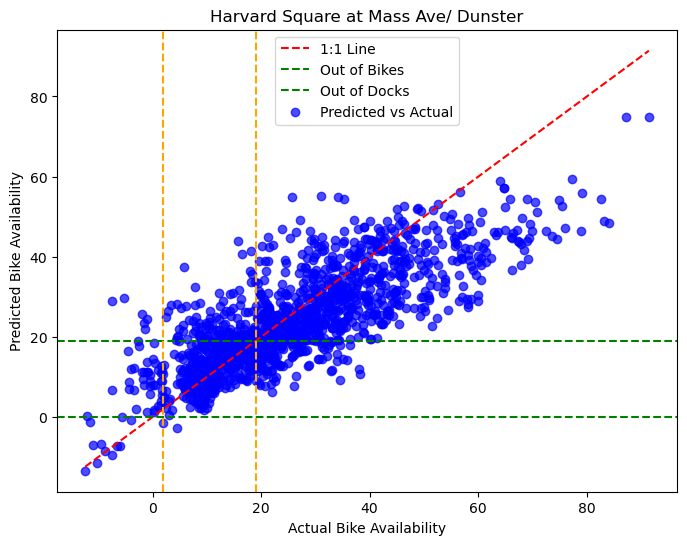

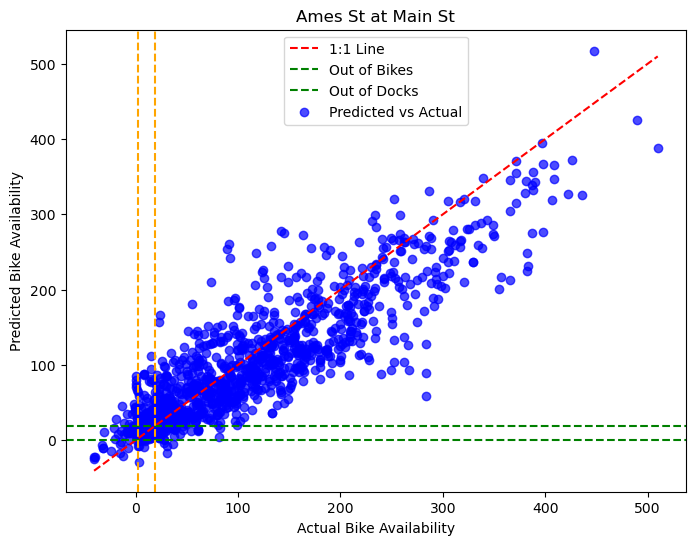

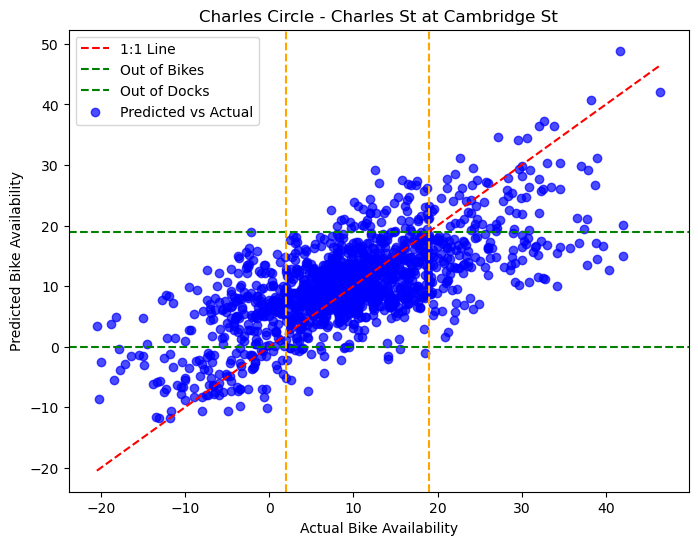

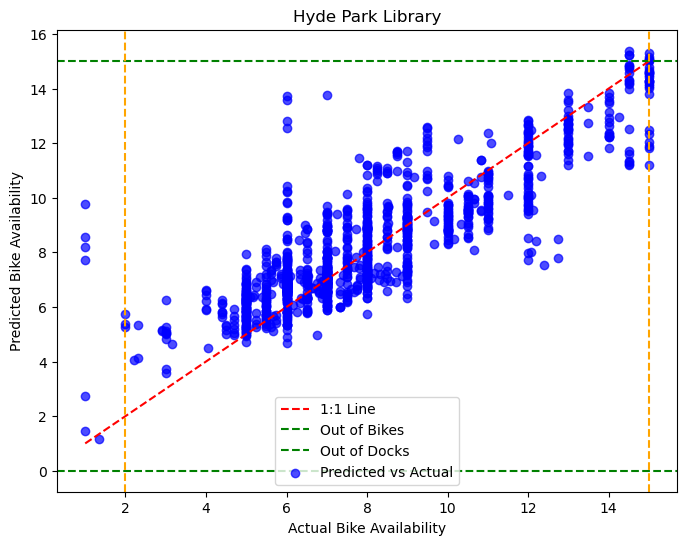

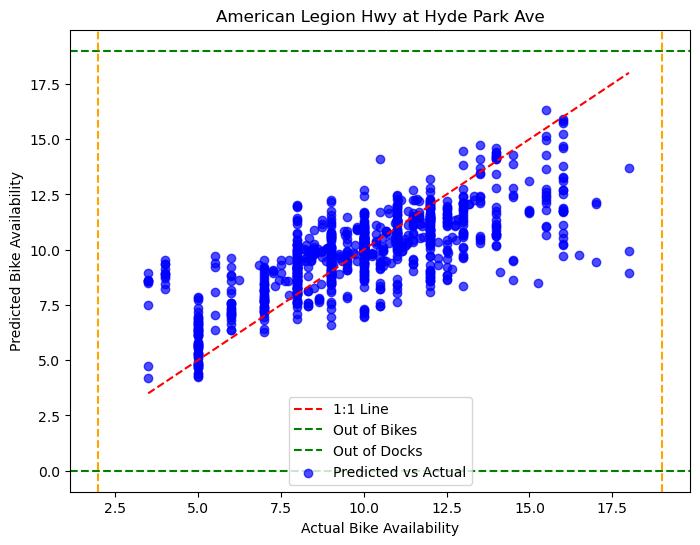

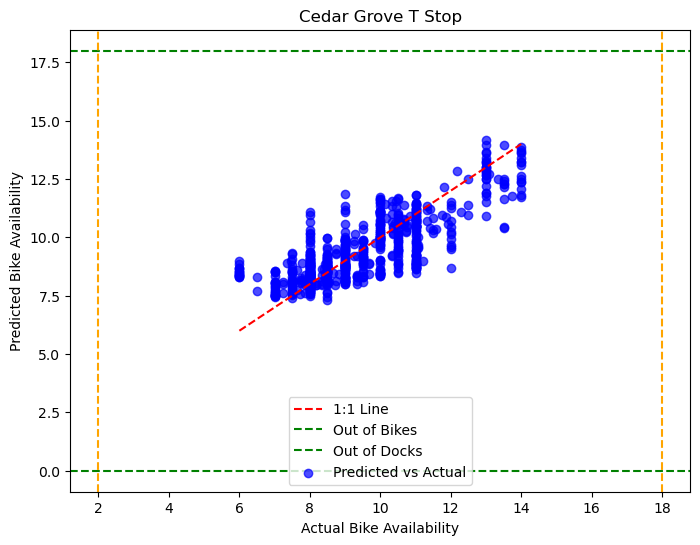

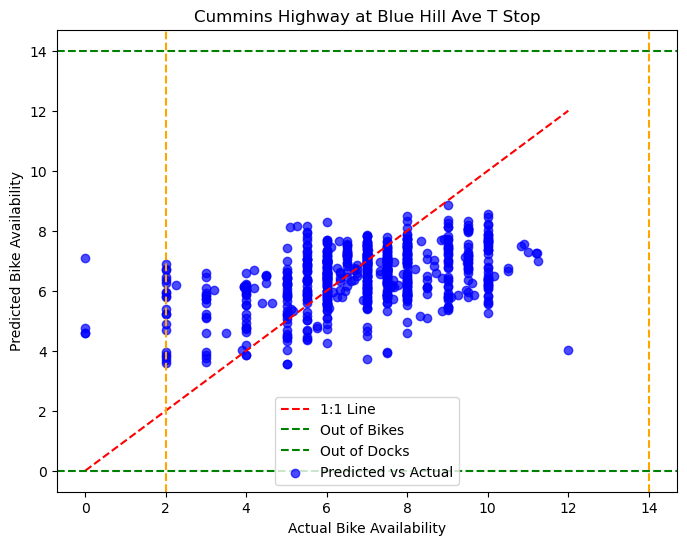

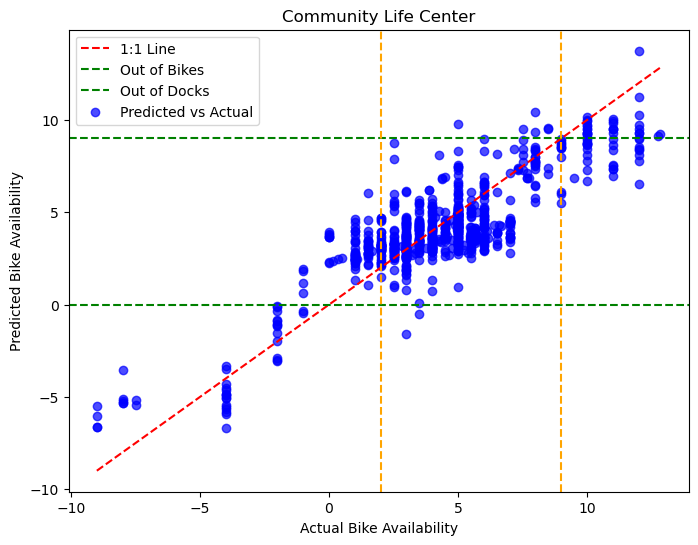

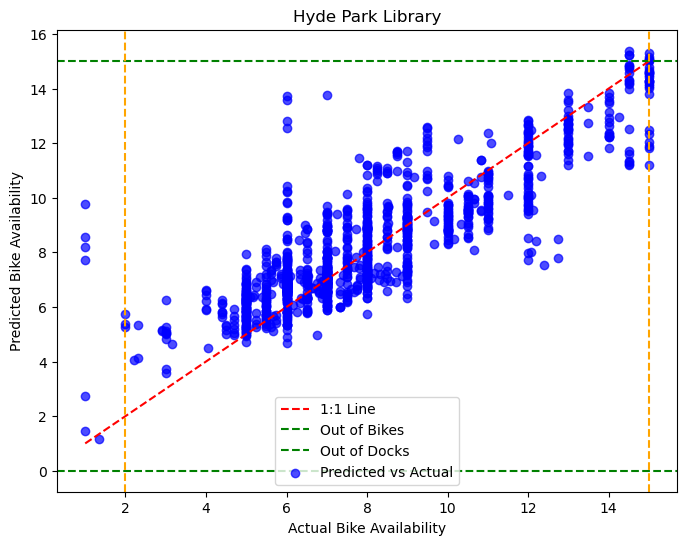

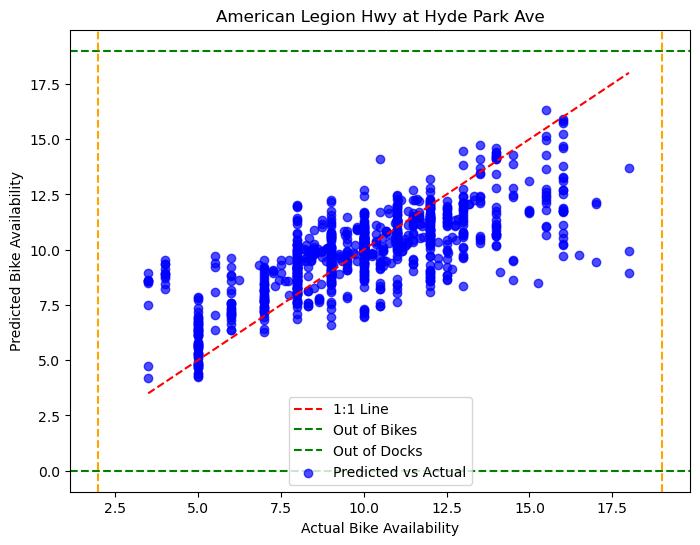

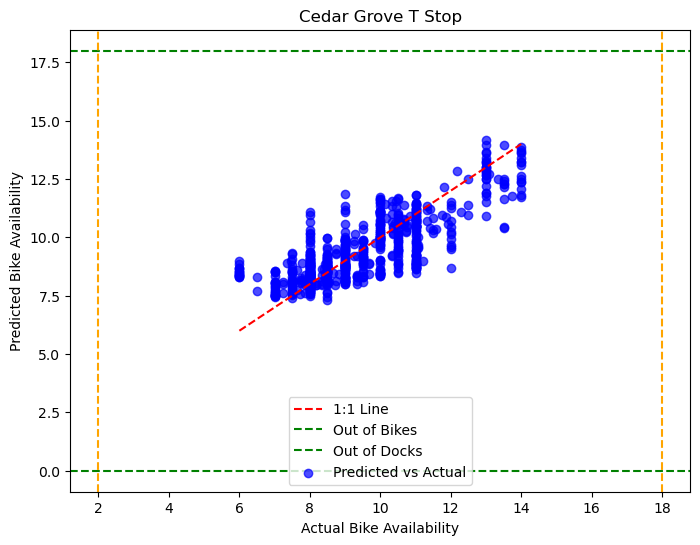

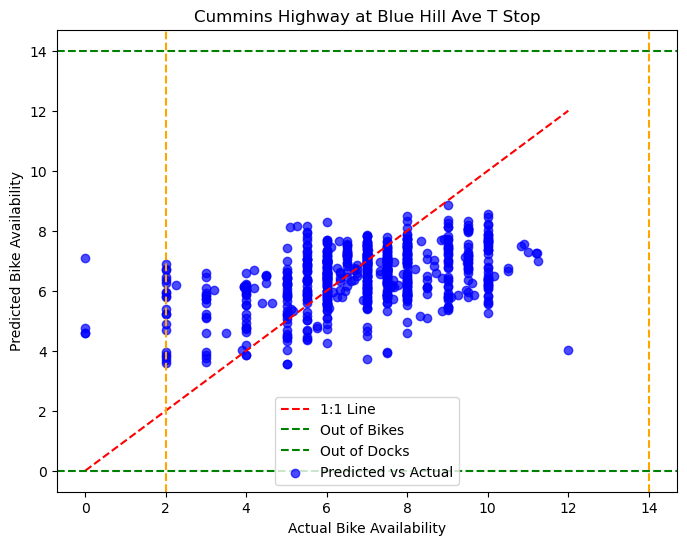

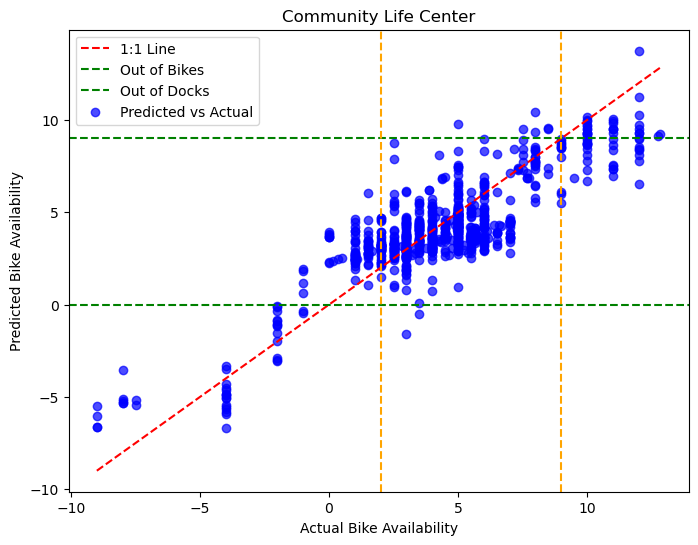

In [17]:
name = 0
for st in [popular_origins, popular_destinations, unpopular_origins, unpopular_destnations]:
    for i in st:
        y_pred = results[i][2].flatten()
        y = results[i][1].flatten()
        # Plotting the actual vs predicted values
        plt.figure(figsize=(8, 6))
        plt.scatter(y, y_pred, alpha=0.7, label='Predicted vs Actual', color='b')
        plt.plot([min(y), max(y)], [min(y), max(y)], color='r', linestyle='--', label='1:1 Line')
        plt.xlabel('Actual Bike Availability')
        plt.ylabel('Predicted Bike Availability')
        plt.axhline(y=0, color='green', linestyle='--', label='Out of Bikes')
        plt.axhline(y=stations['Total Docks'][i], color='green', linestyle='--', label='Out of Docks')
        plt.axvline(x=2, color='orange', linestyle='--')
        plt.axvline(x=stations['Total Docks'][i], color='orange', linestyle='--')
        plt.title(f'{stations.NAME[i]}')
        plt.legend()
        plt.show()
        
        
#         plt.savefig(f'{name}.png')
#         name += 1


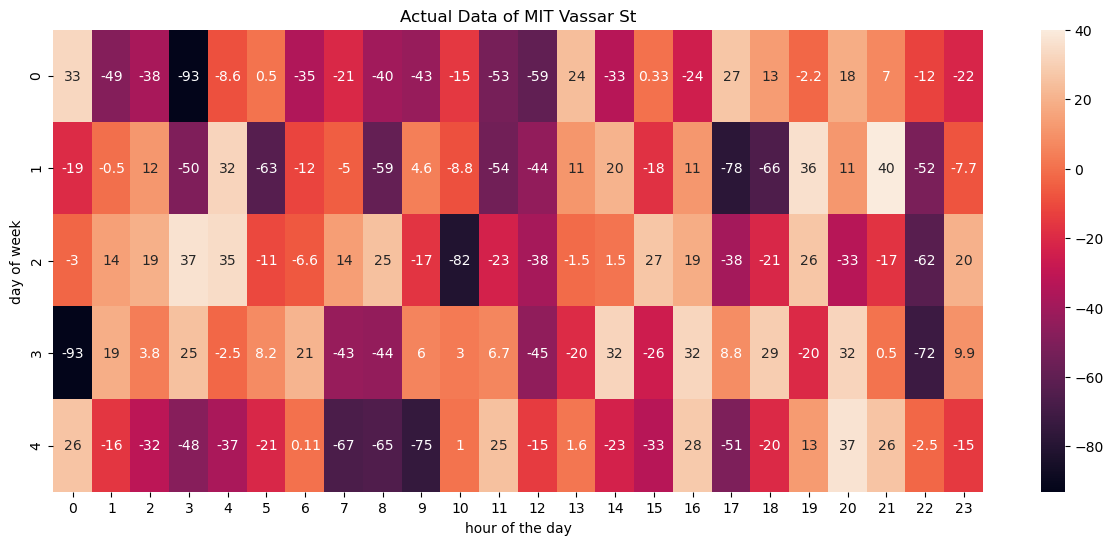

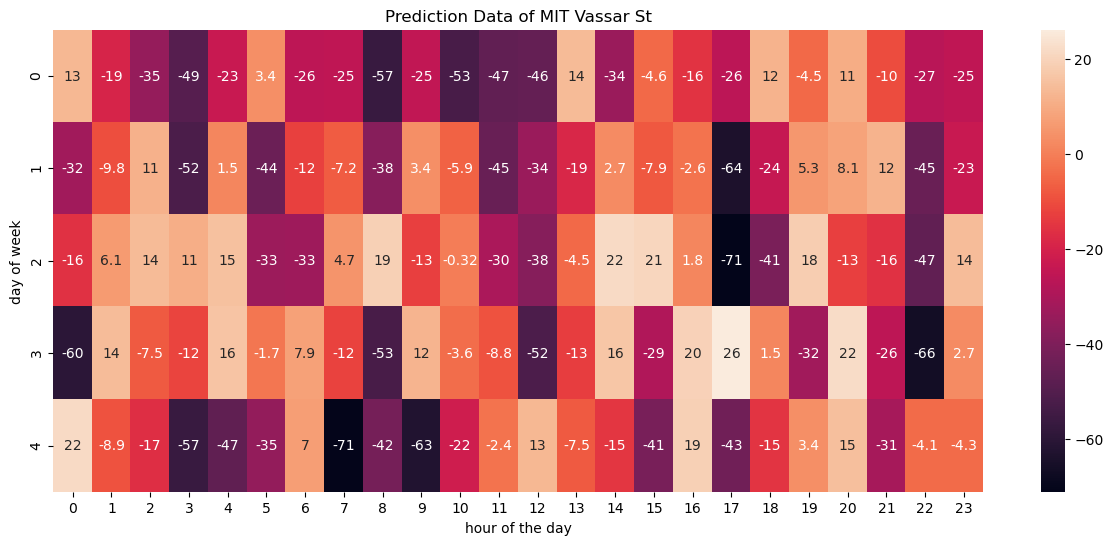

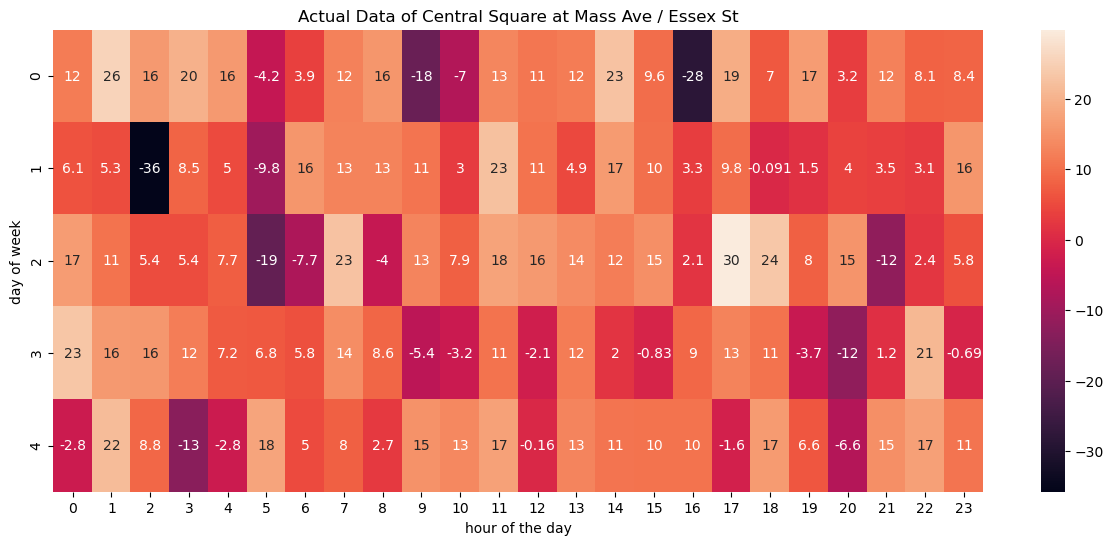

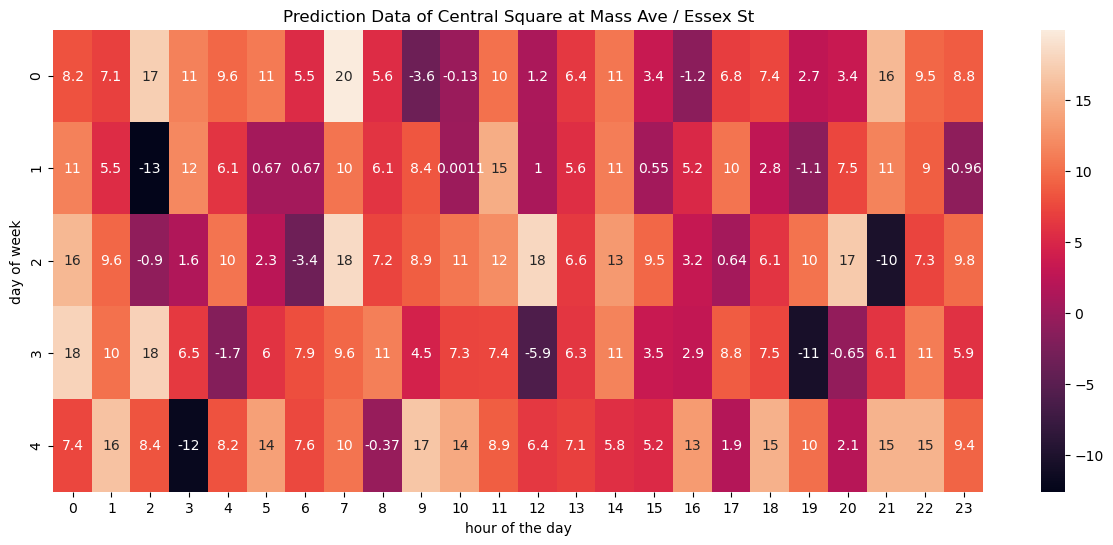

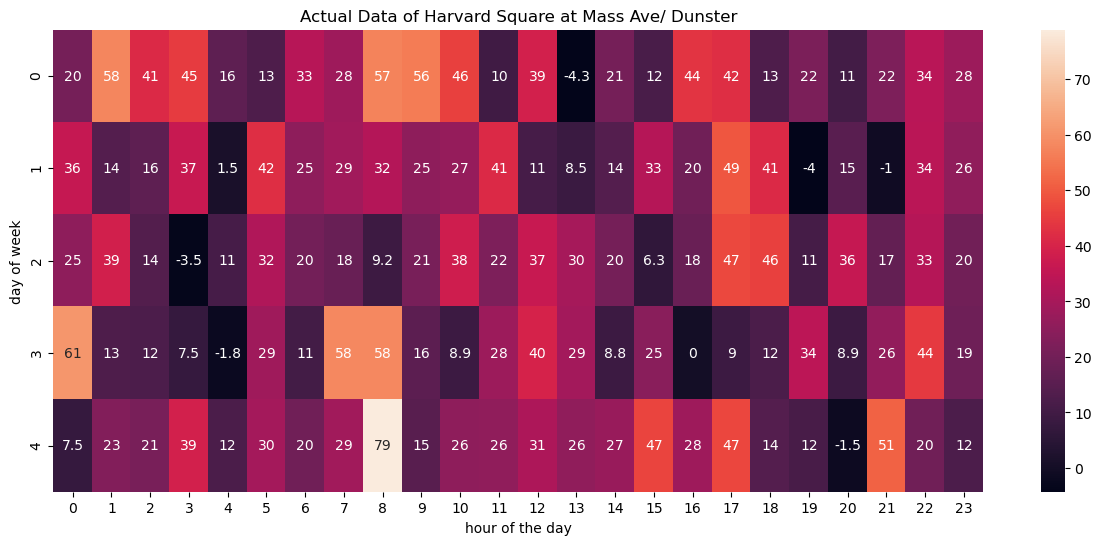

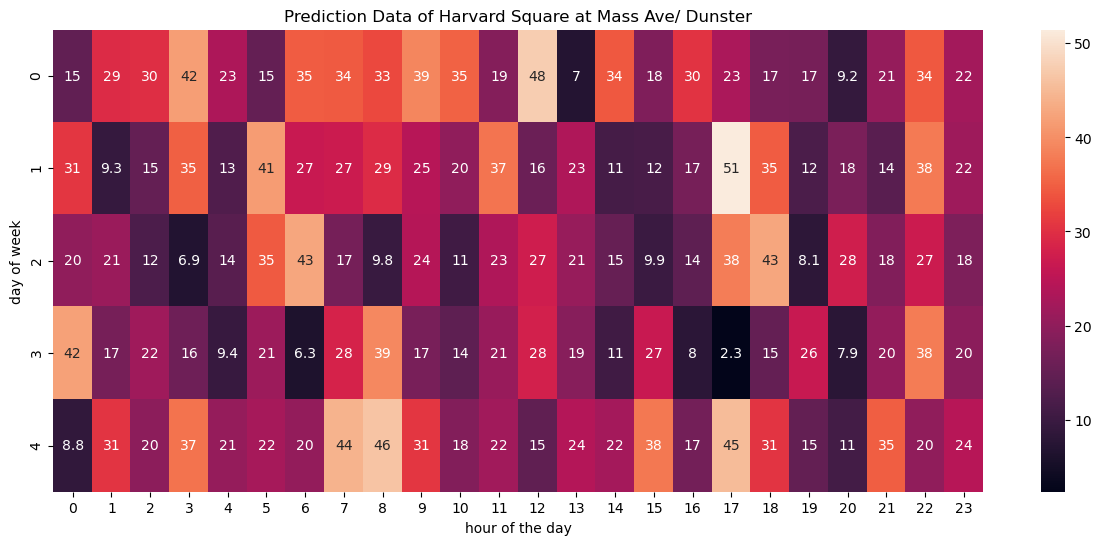

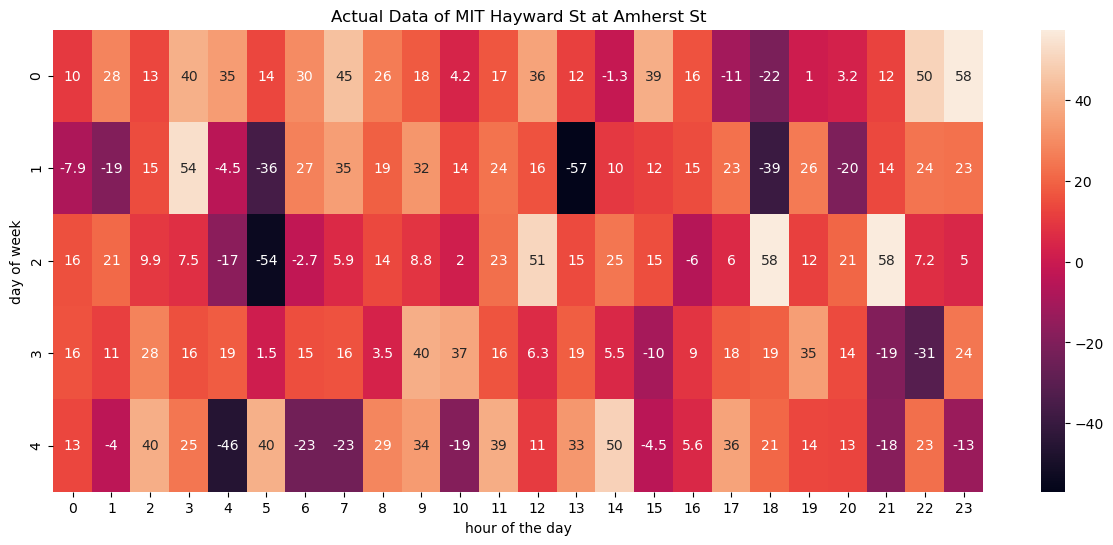

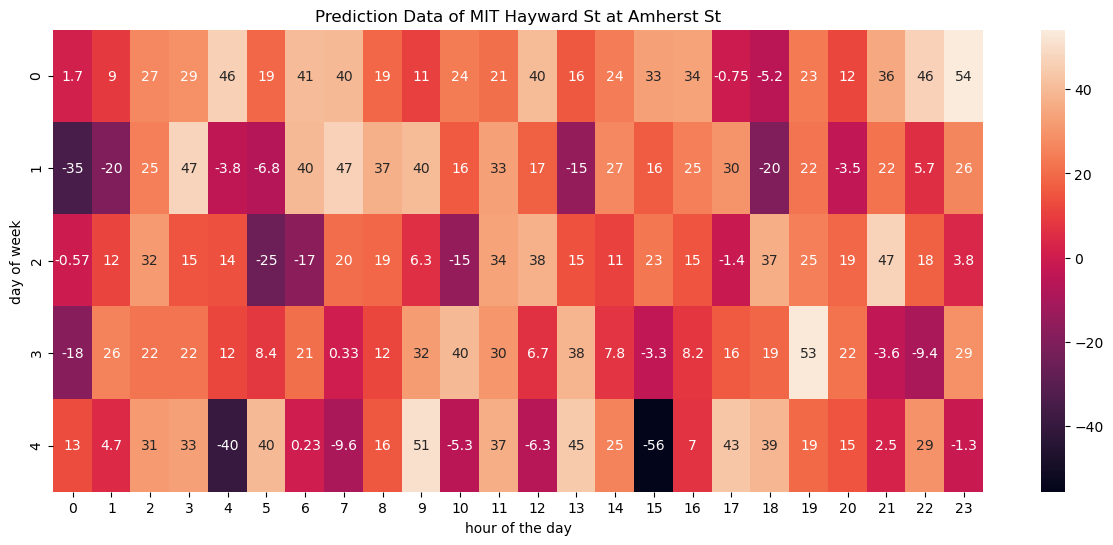

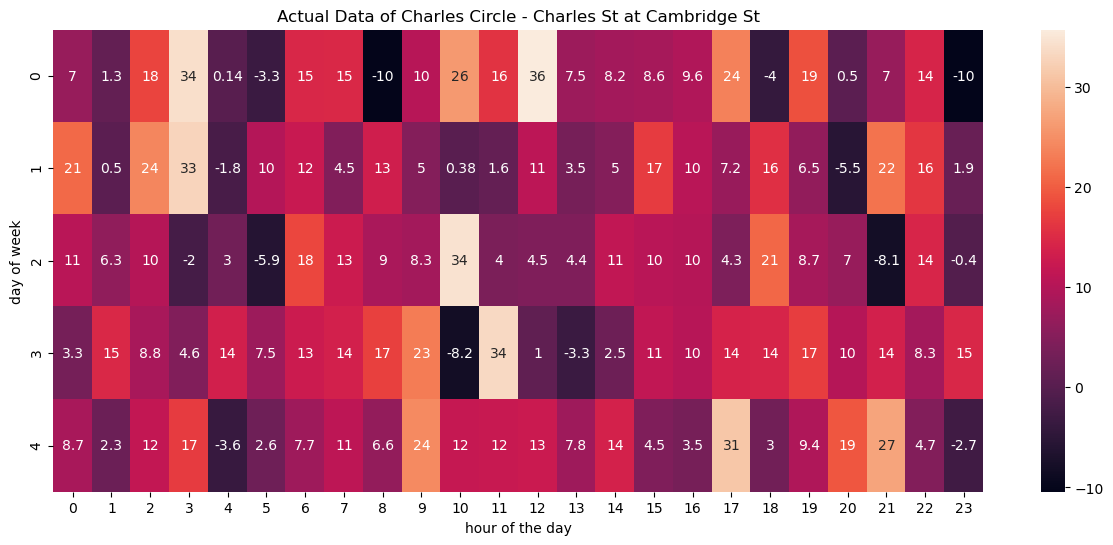

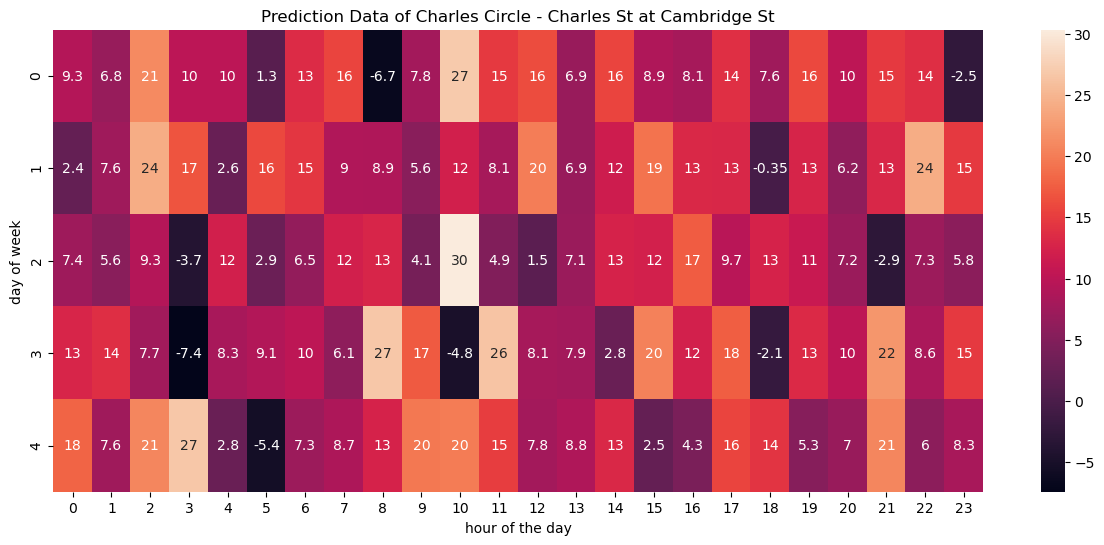

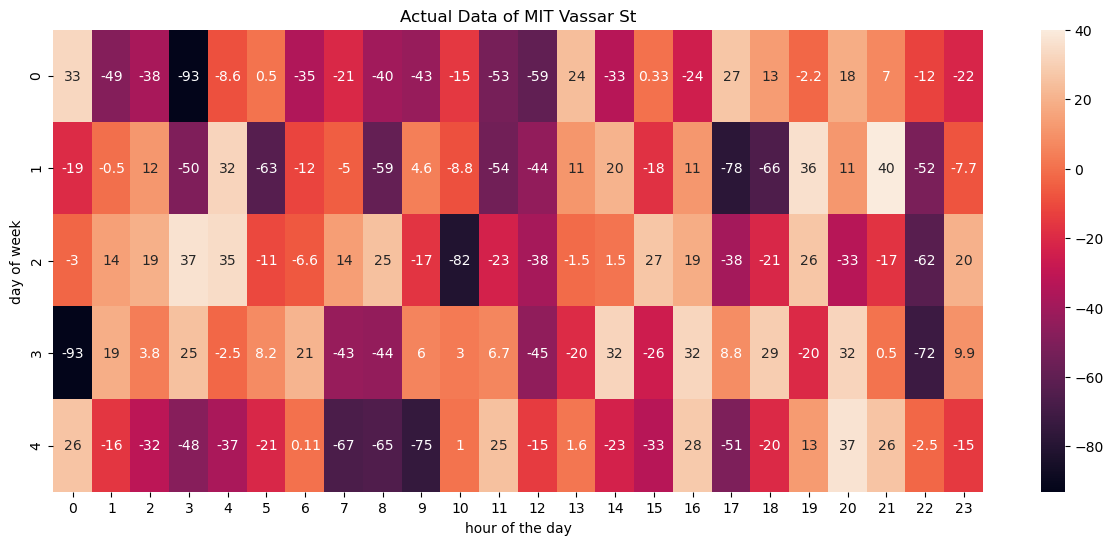

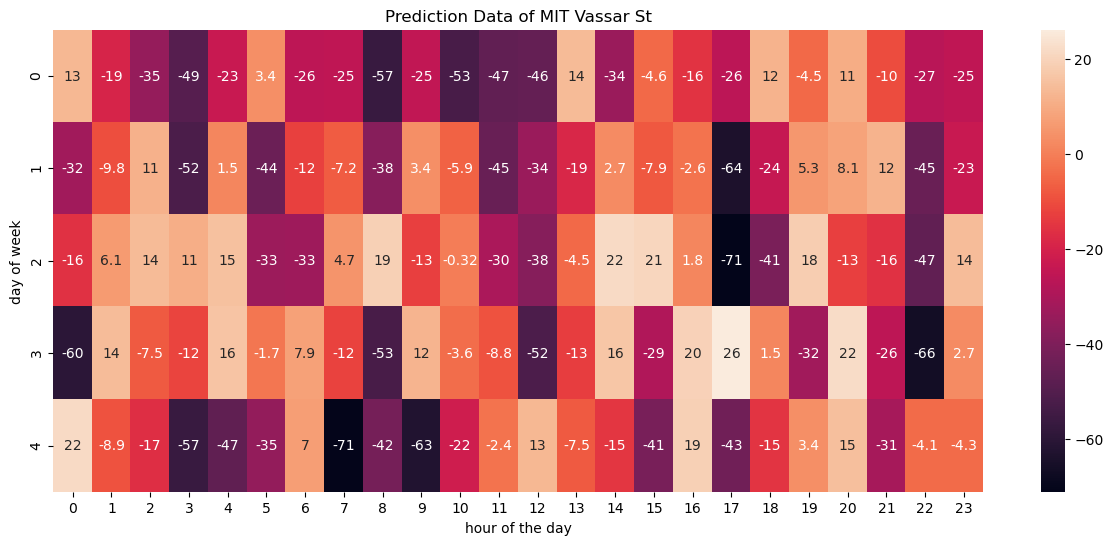

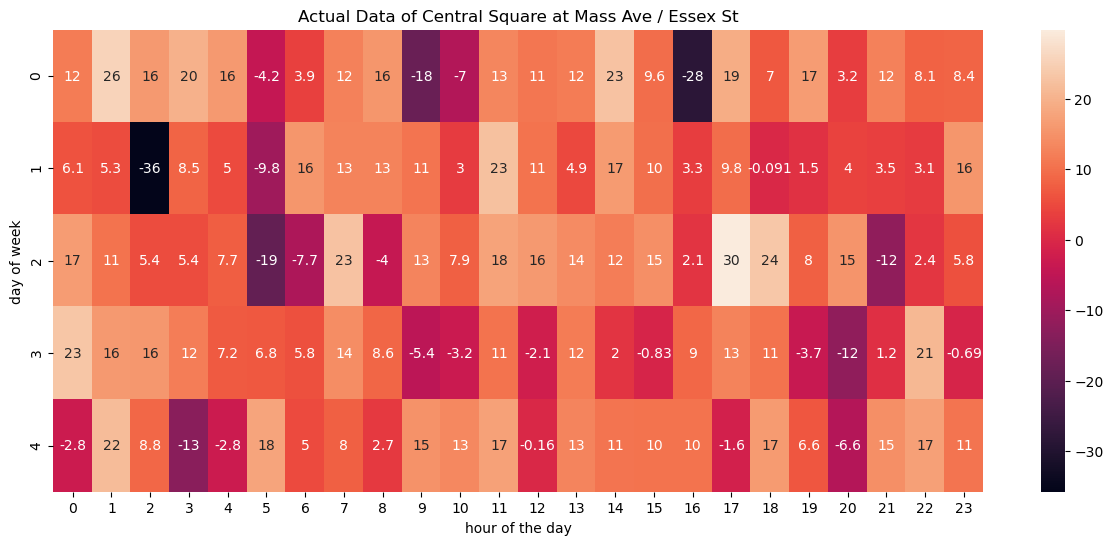

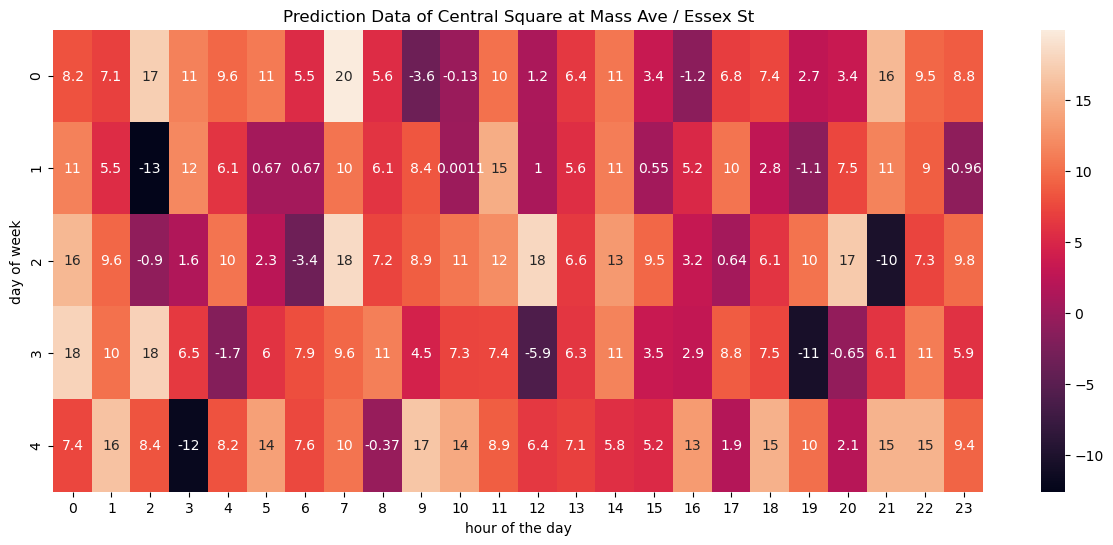

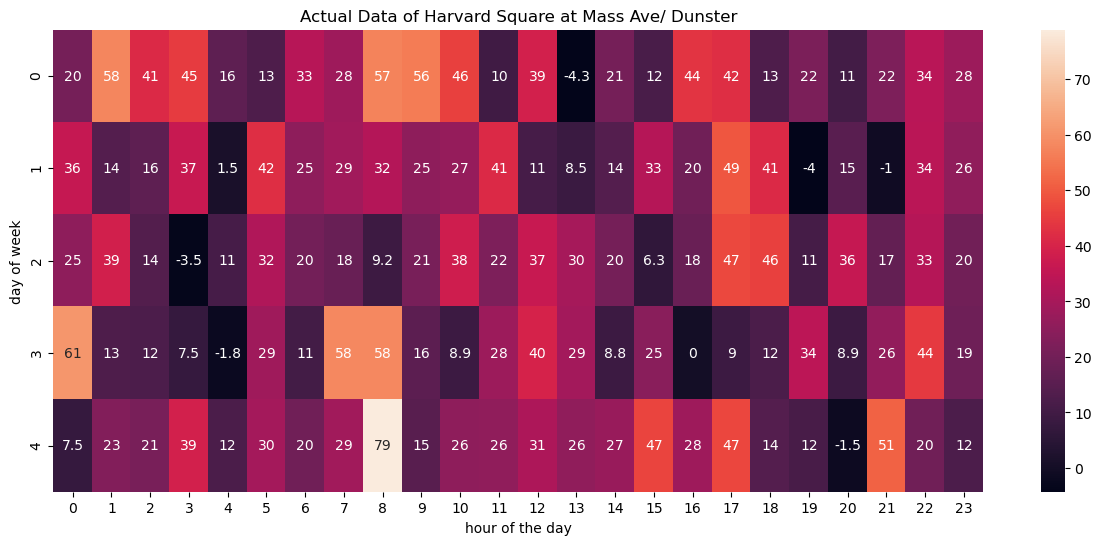

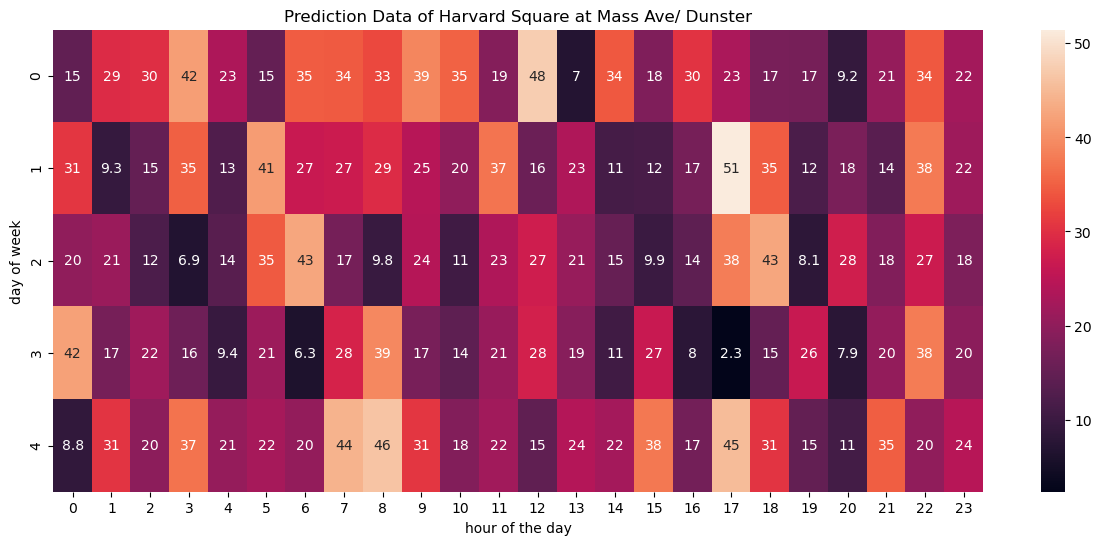

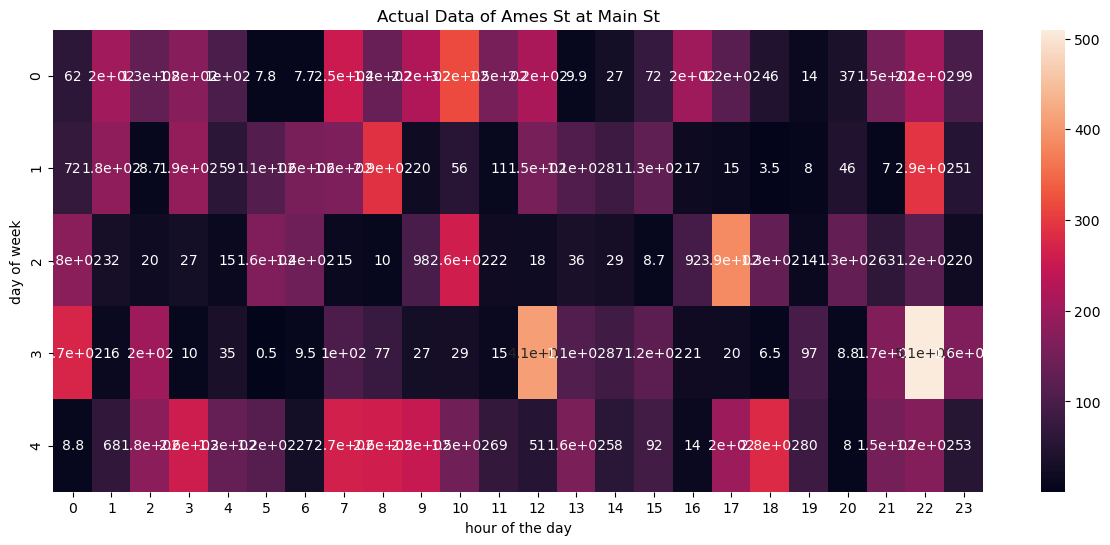

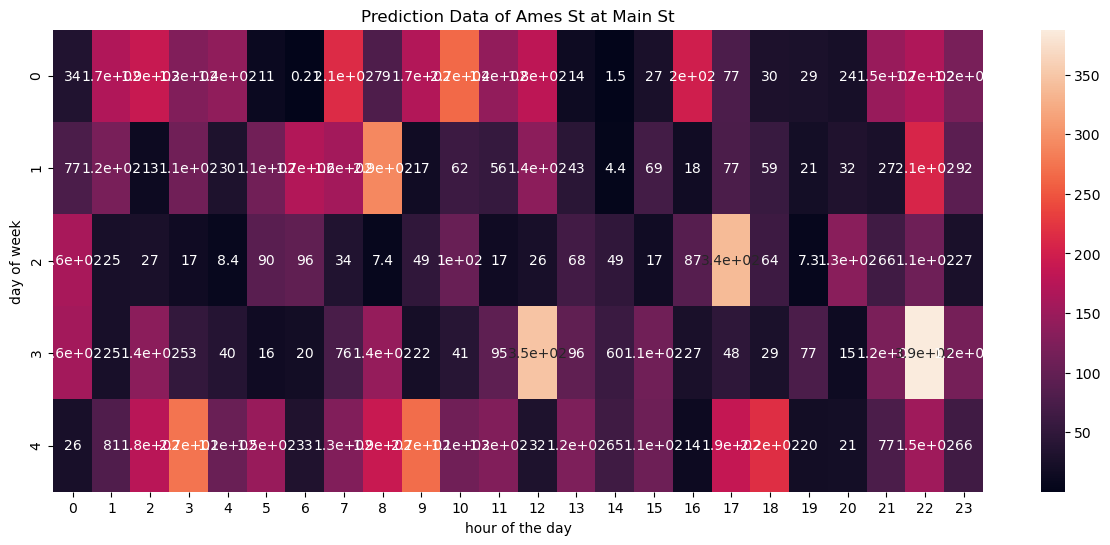

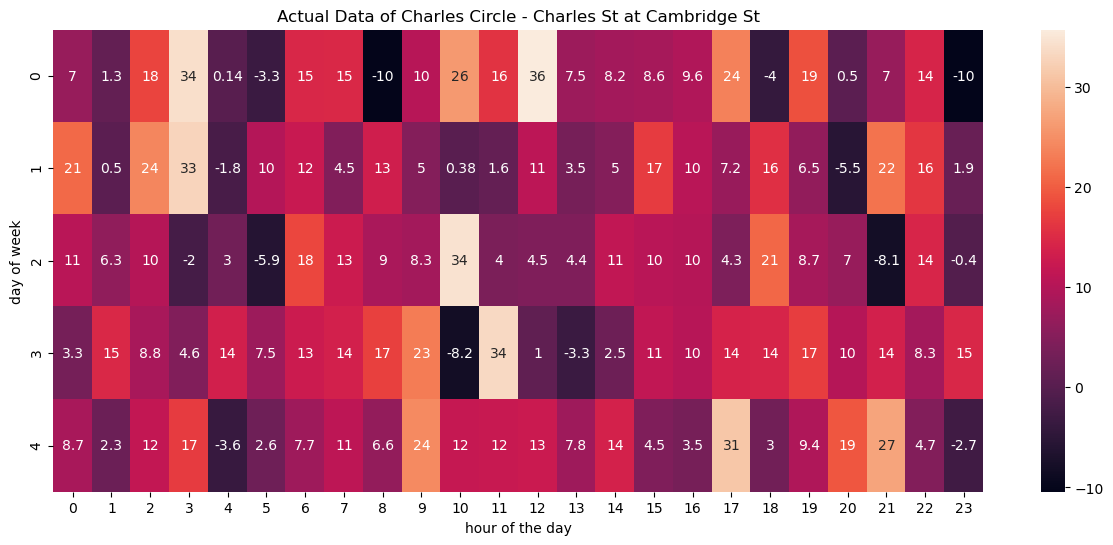

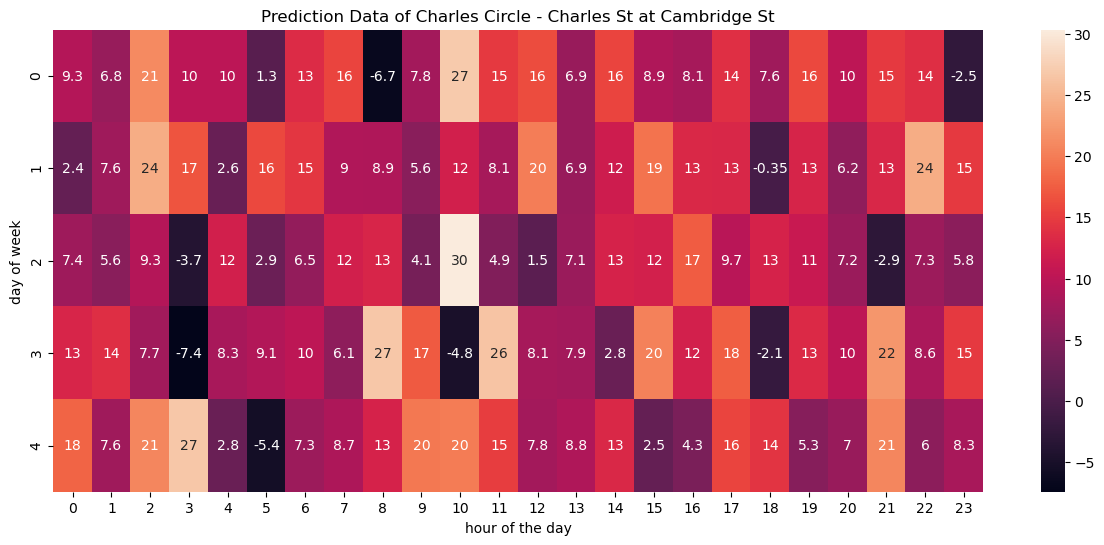

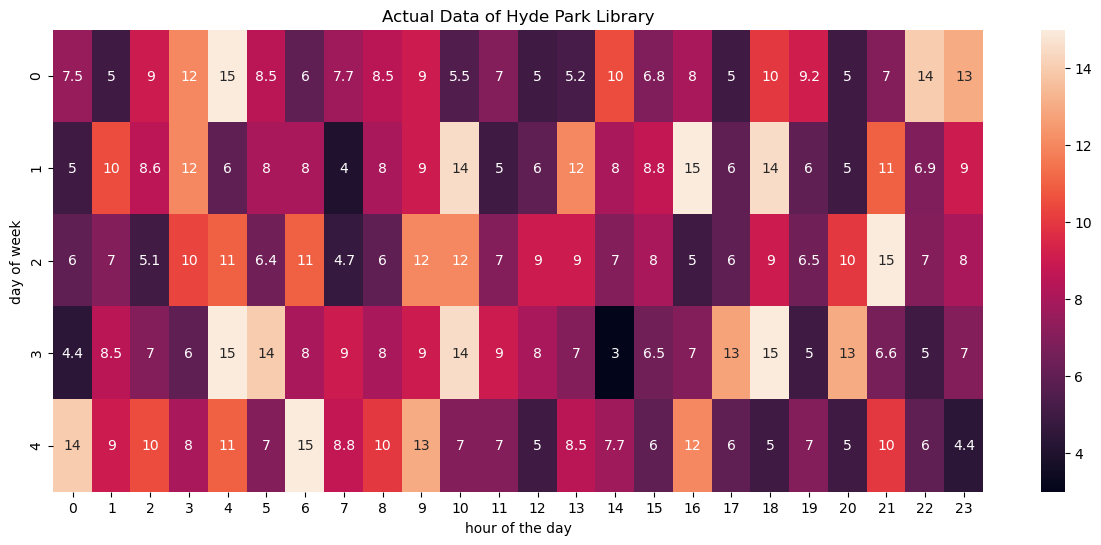

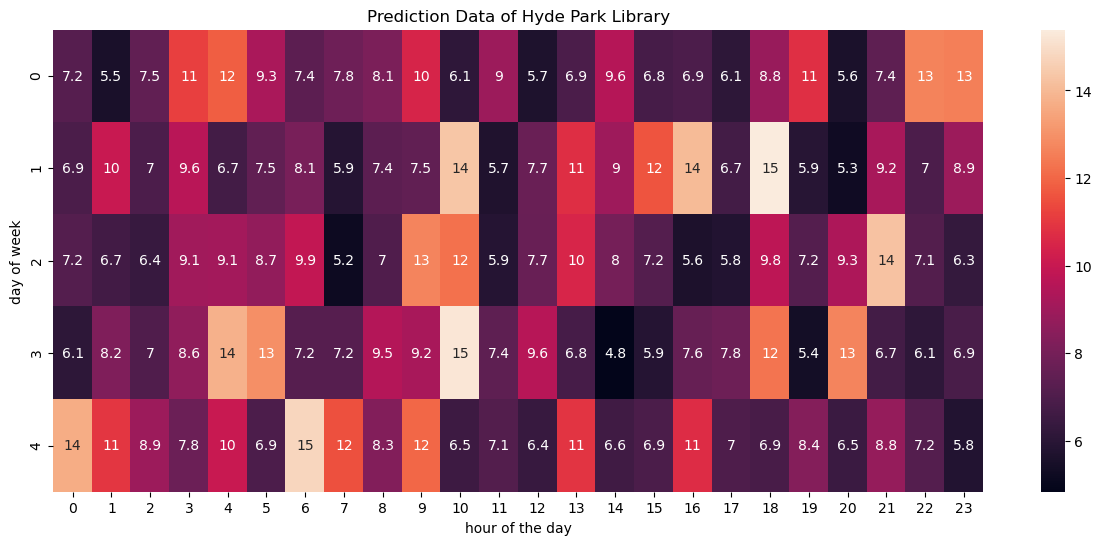

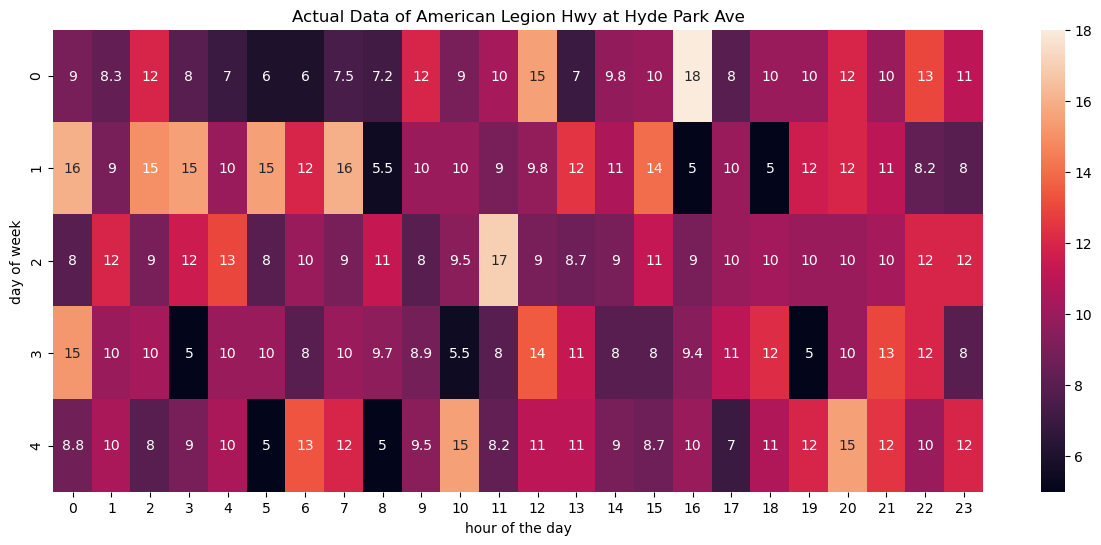

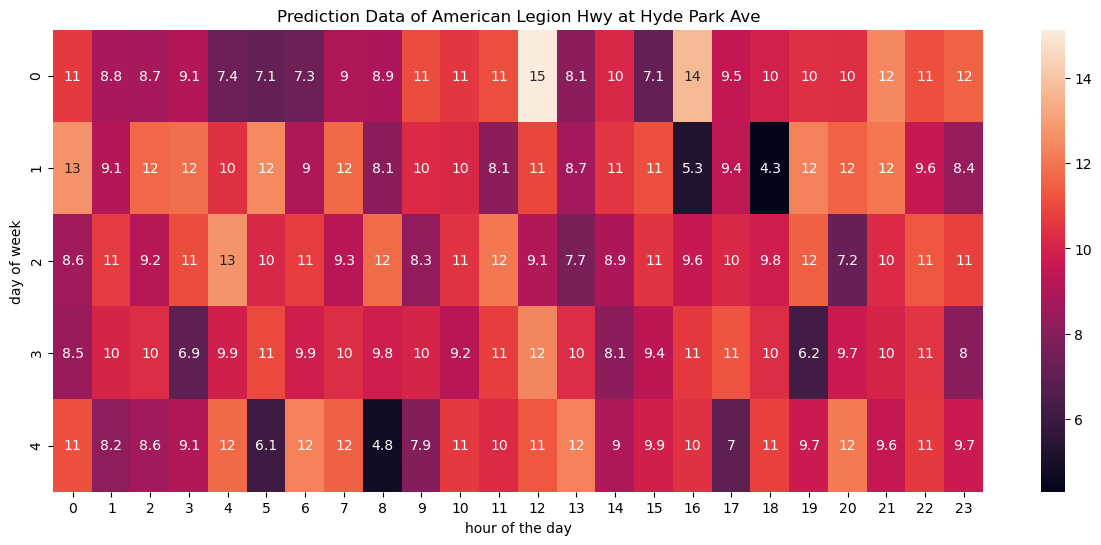

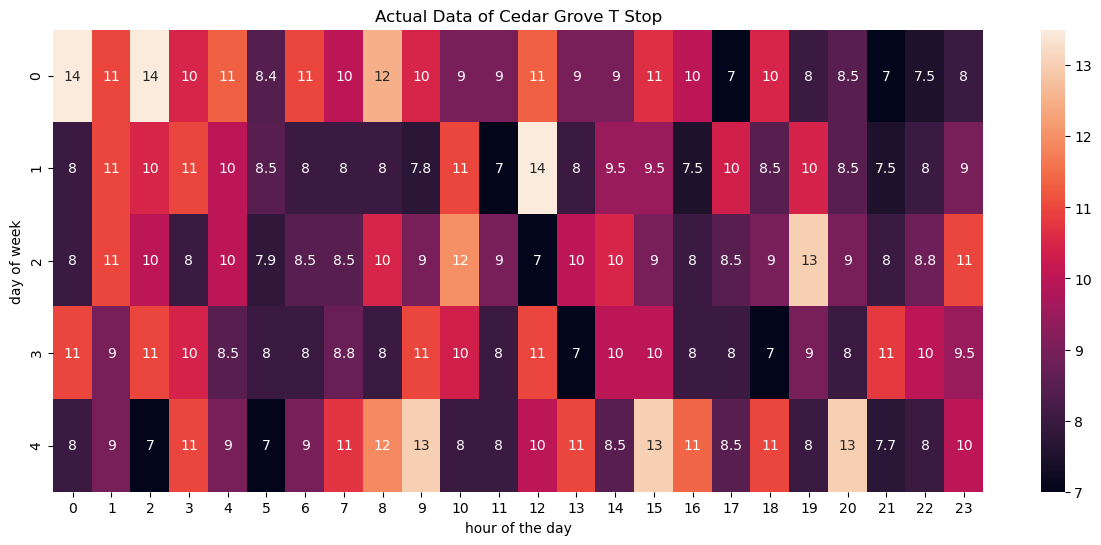

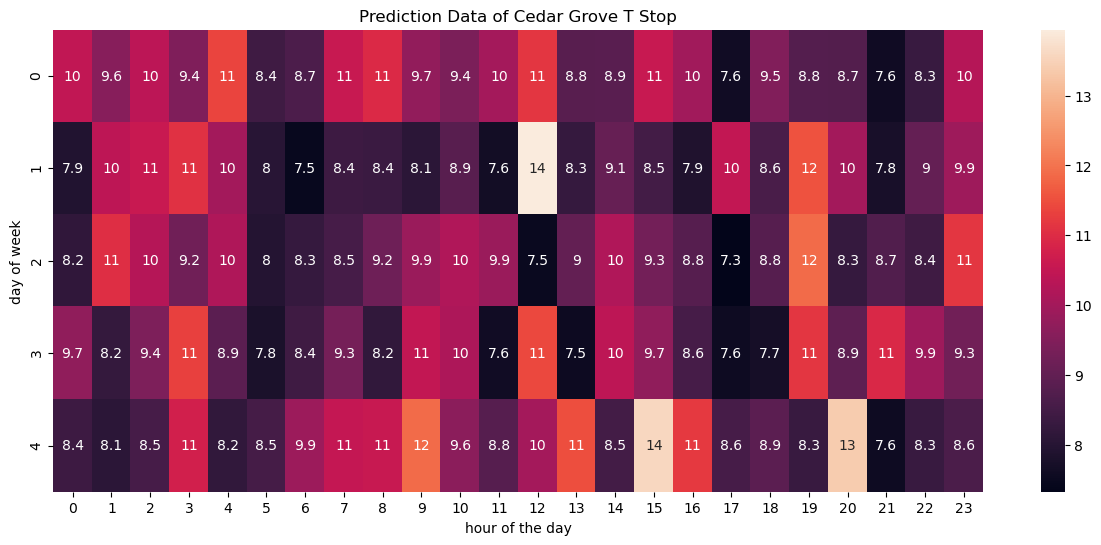

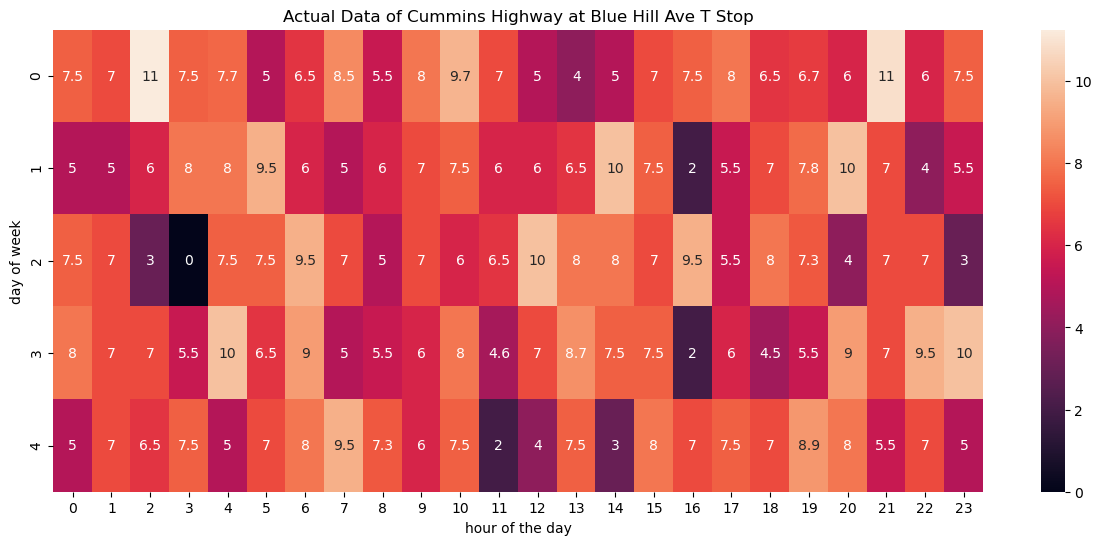

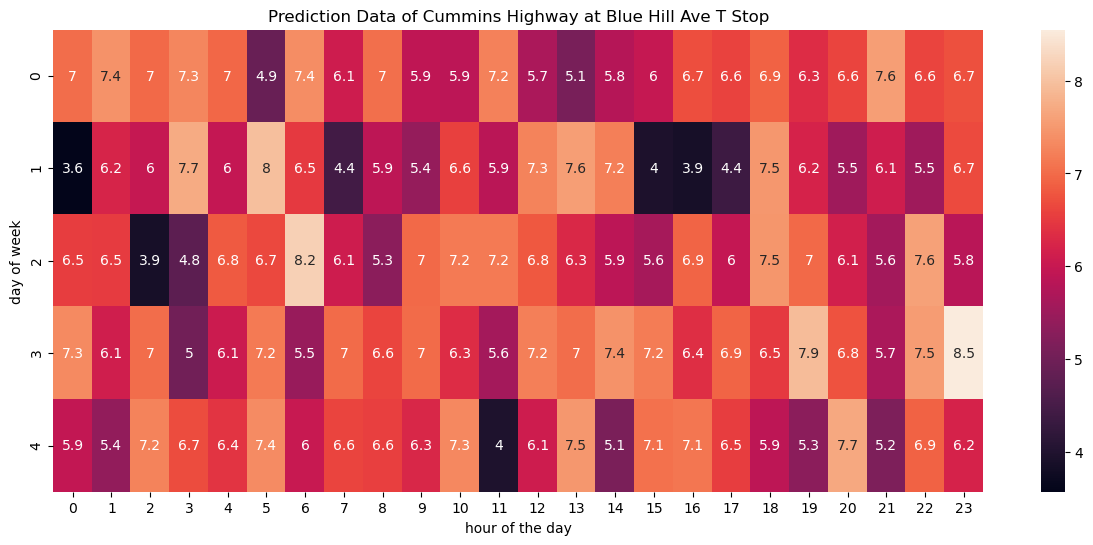

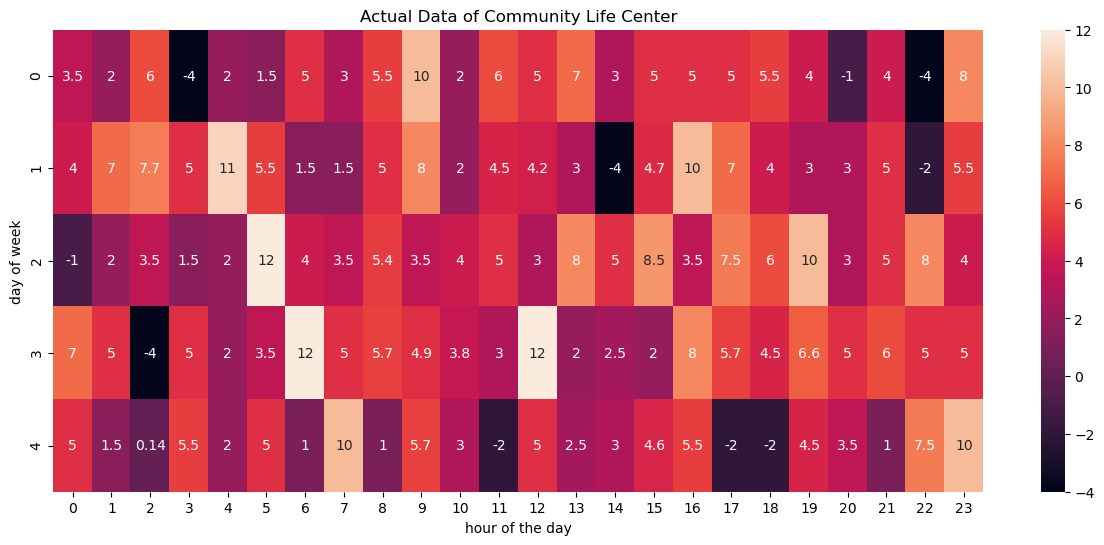

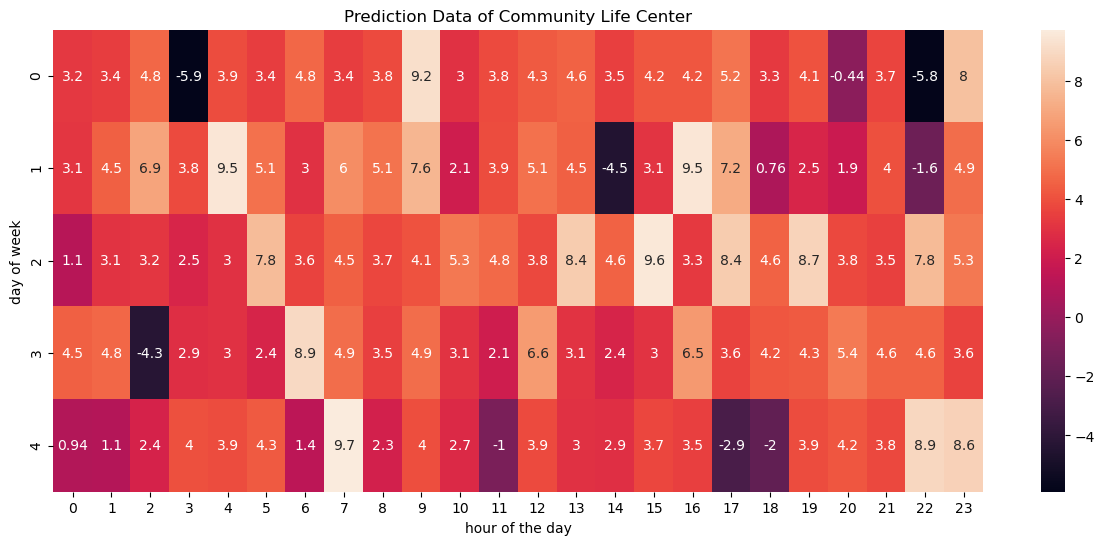

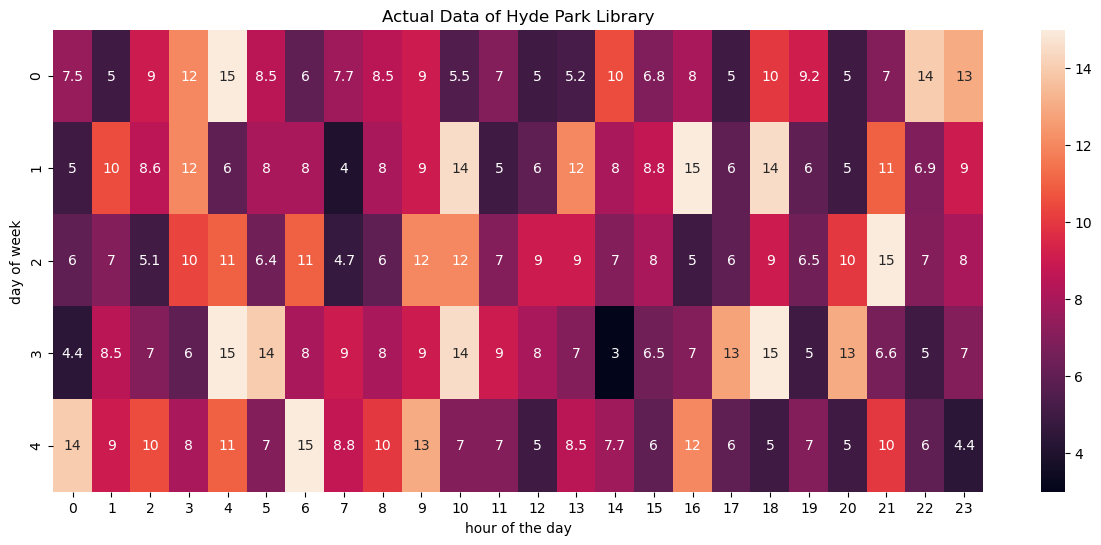

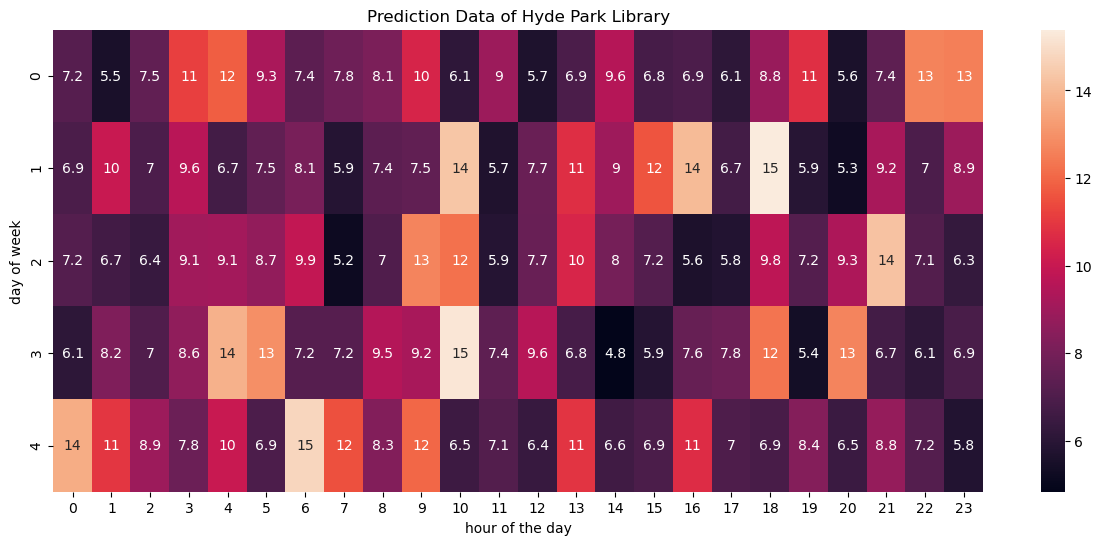

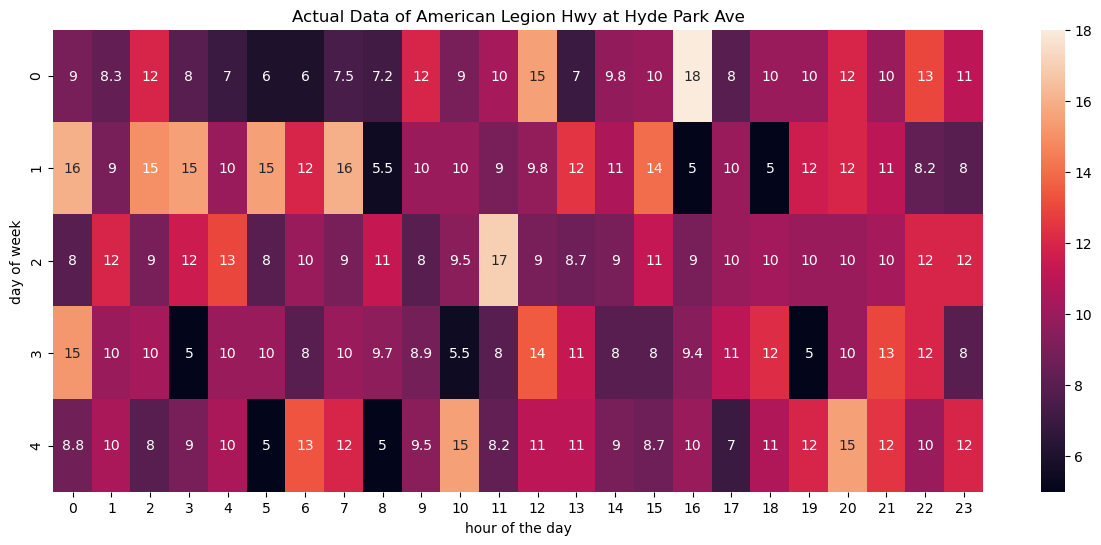

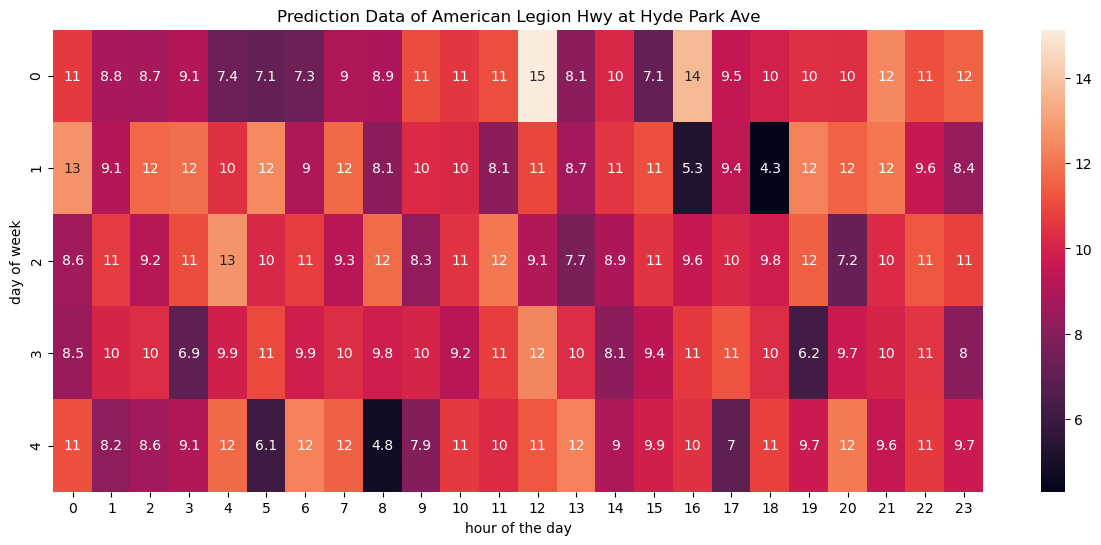

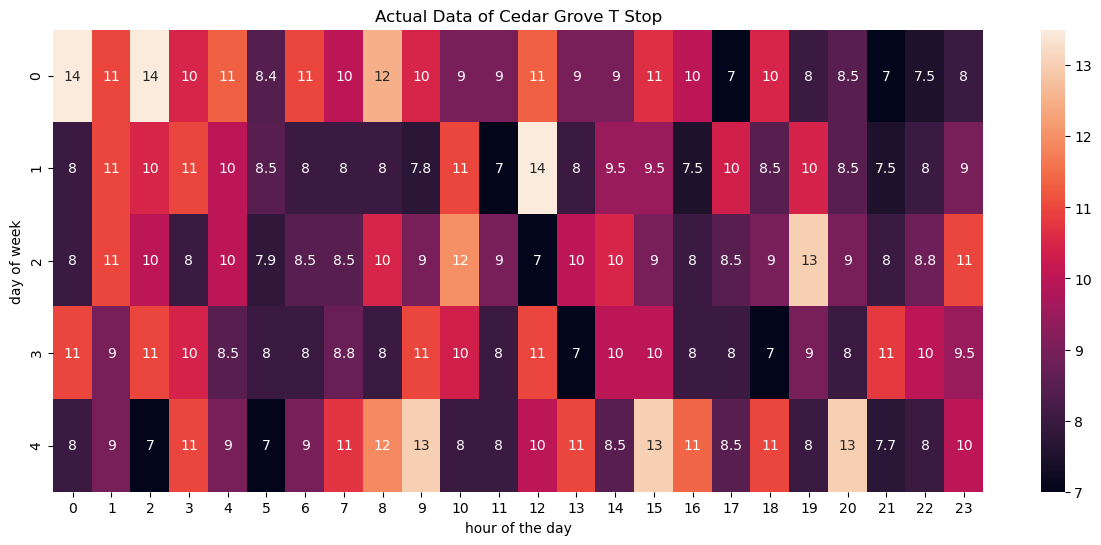

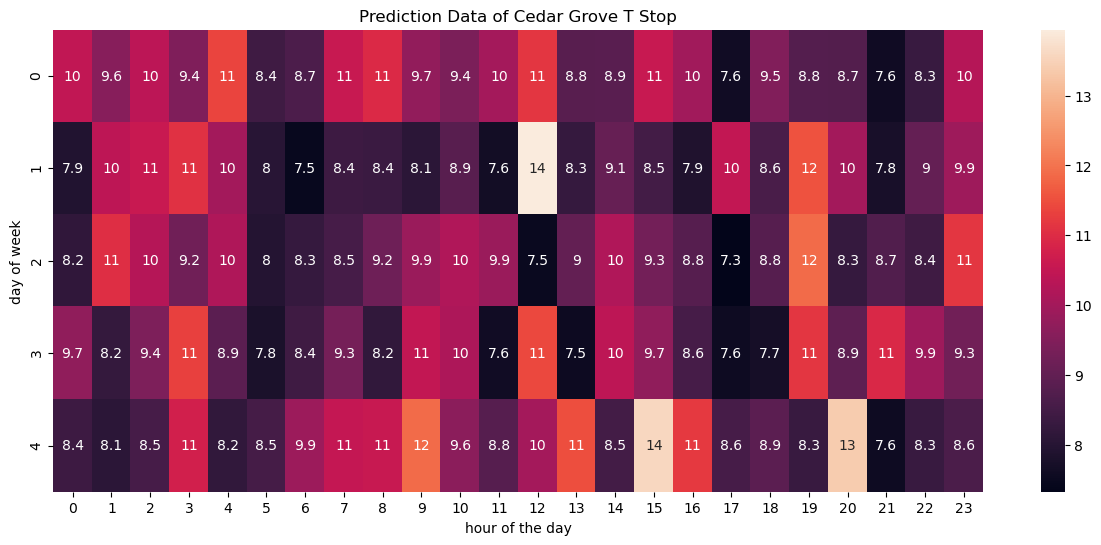

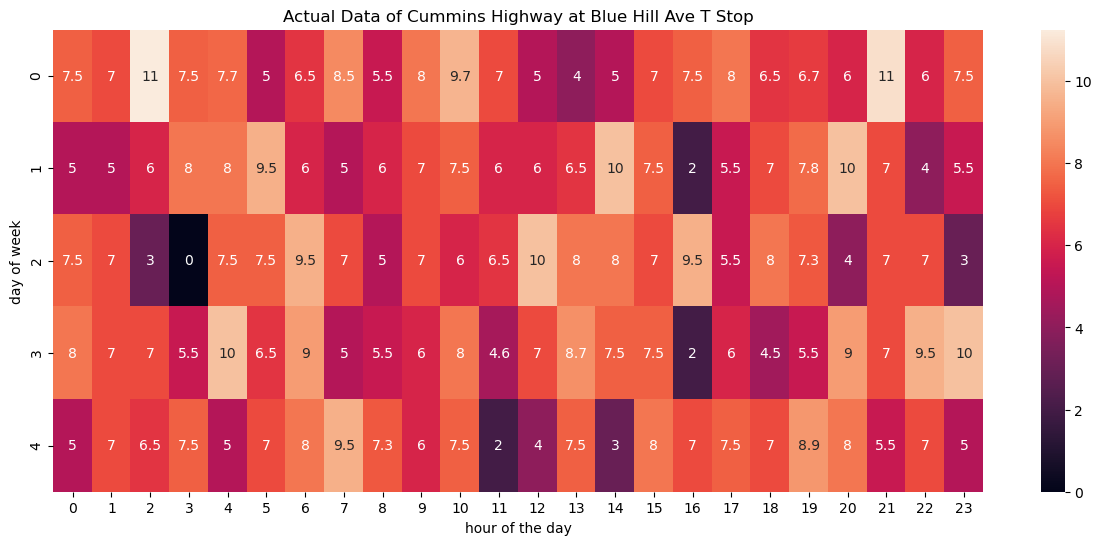

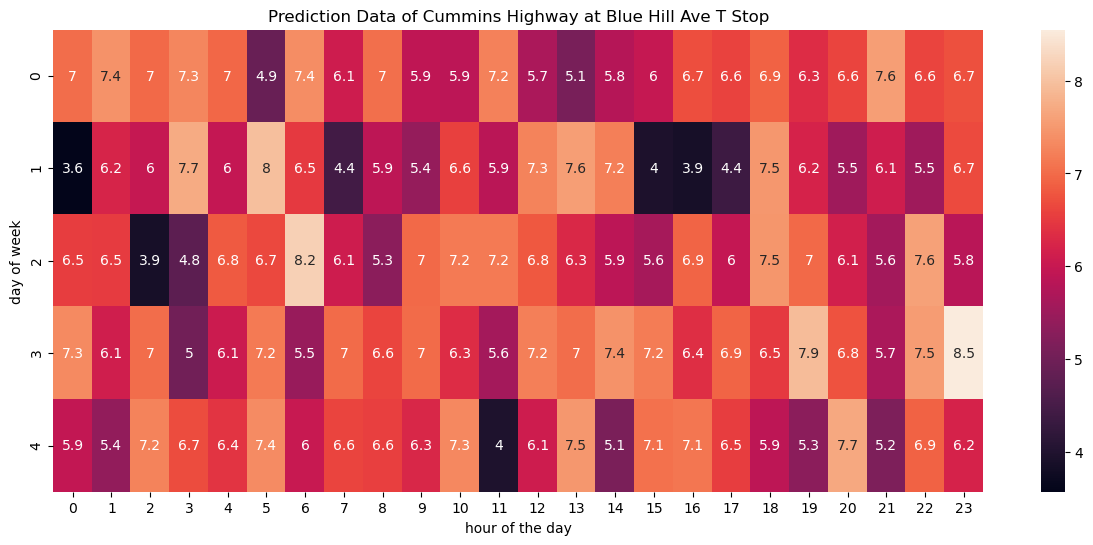

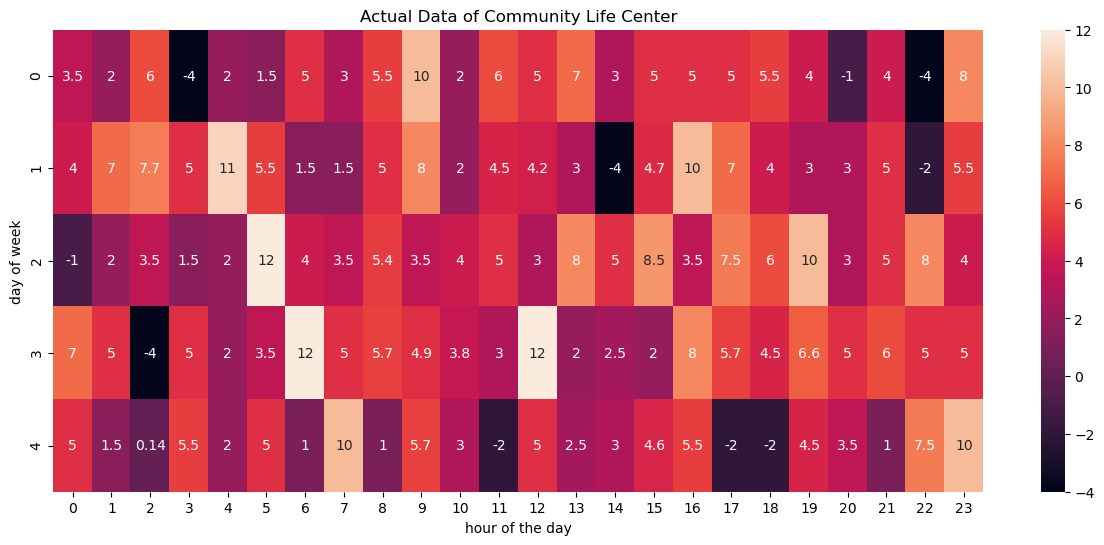

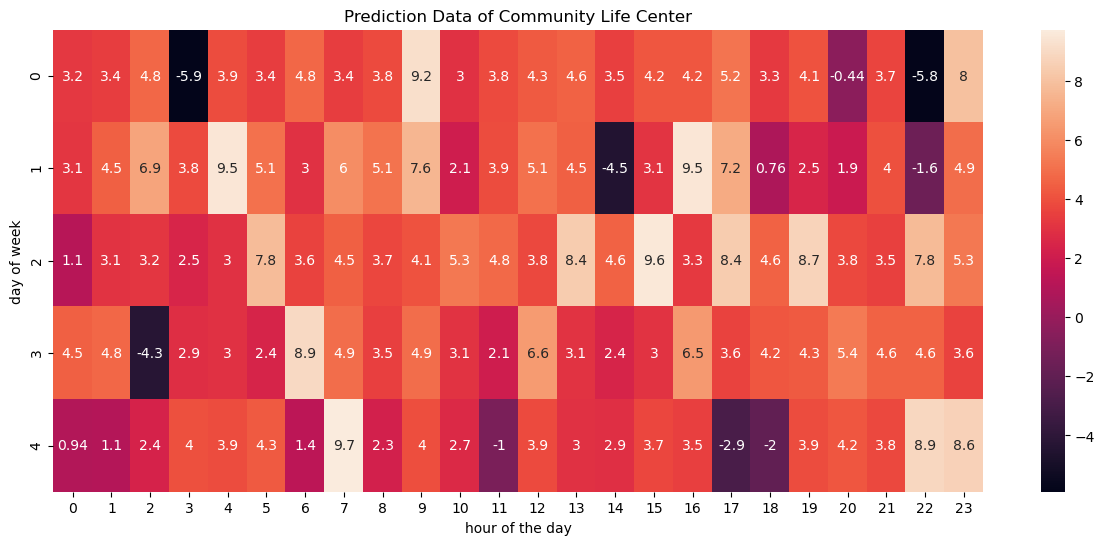

In [18]:
for st in [popular_origins, popular_destinations, unpopular_origins, unpopular_destnations]:
    for i in st:
        plt.figure(figsize=(15, 6))
        sns.heatmap(results[i][1][0], annot=True)
        plt.xlabel("hour of the day")
        plt.ylabel("day of week")
        plt.title(f"Actual Data of {stations.NAME[i]}")
        plt.show()
        
        plt.figure(figsize=(15, 6))
        sns.heatmap(results[i][2][0], annot=True)
        plt.xlabel("hour of the day")
        plt.ylabel("day of week")
        plt.title(f"Prediction Data of {stations.NAME[i]}")
        plt.show()

# for st in [popular_origins, popular_destinations, unpopular_origins, unpopular_destnations]:
#     for i in st:
#         plt.figure(figsize=(15, 6))
#         sns.heatmap(results[i][2][-1], annot=True)
#         plt.xlabel("hour of the day")
#         plt.ylabel("day of week")
#         plt.title(f"Prediction Data of {stations.NAME[i]}")
#         plt.show()

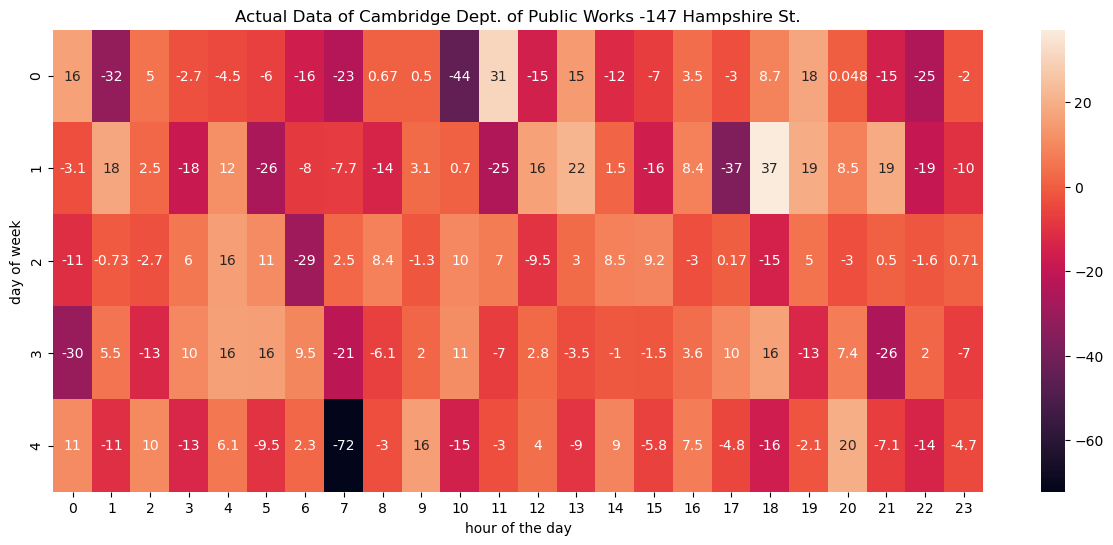

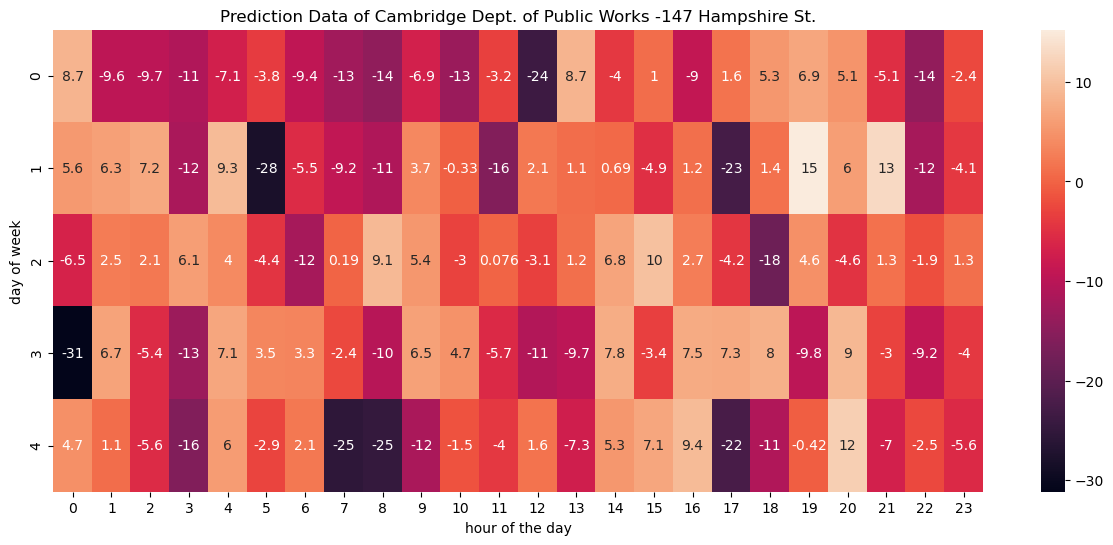

In [19]:
plt.figure(figsize=(15, 6))
sns.heatmap(results[100][1][0], annot=True)
plt.xlabel("hour of the day")
plt.ylabel("day of week")
plt.title(f"Actual Data of {stations.NAME[100]}")
plt.show()

plt.figure(figsize=(15, 6))
sns.heatmap(results[100][2][0], annot=True)
plt.xlabel("hour of the day")
plt.ylabel("day of week")
plt.title(f"Prediction Data of {stations.NAME[100]}")
plt.show()

In [20]:
for st in [popular_origins, popular_destinations, unpopular_origins, unpopular_destnations]:
    for i in st:
        print(stations.NAME[i])
        print(RMSEs[i])
        print(respective_error[i])
        print('\n\n')

MIT Vassar St
18.645063277058867
0.35179364673695973



Central Square at Mass Ave / Essex St
8.646316220490677
0.45506927476266723



Harvard Square at Mass Ave/ Dunster
10.134725007238044
0.5334065793283181



MIT Hayward St at Amherst St
15.87791586013524
0.5880709577827866



Charles Circle - Charles St at Cambridge St
7.306058905963013
0.3845294161033165



MIT Vassar St
18.645063277058867
0.35179364673695973



Central Square at Mass Ave / Essex St
8.646316220490677
0.45506927476266723



Harvard Square at Mass Ave/ Dunster
10.134725007238044
0.5334065793283181



Ames St at Main St
42.86579892784716
2.256094680413008



Charles Circle - Charles St at Cambridge St
7.306058905963013
0.3845294161033165



Hyde Park Library
1.4285448867914994
0.09523632578609996



American Legion Hwy at Hyde Park Ave
1.8566223836124203
0.09771696755854843



Cedar Grove T Stop
1.0276263444604947
0.057090352470027486



Cummins Highway at Blue Hill Ave T Stop
1.8121348141009177
0.1294382010072084




In [21]:
closure = pd.read_csv('winter closure.csv')

winter_closure = pd.DataFrame({'station': [np.where(stations.NAME == i)[0][0] for i in closure.station_name], 'start': pd.to_datetime(closure.closure_start).dt.date,
                              'end': pd.to_datetime(closure.closure_end).dt.date})
winter_closure

station       start         end
0        39  2023-12-05  2024-03-27
1        42  2023-12-06  2024-03-29
2        50  2023-12-07  2024-03-27
3        98  2023-12-04  2024-03-30
4       112  2023-12-21  2024-03-29
..      ...         ...         ...
59      459  2023-10-30  2024-04-09
60      460  2023-11-04  2024-03-20
61      464  2023-11-13  2024-03-26
62      468  2023-11-11  2024-03-25
63      479  2023-10-30  2024-04-09

[64 rows x 3 columns]

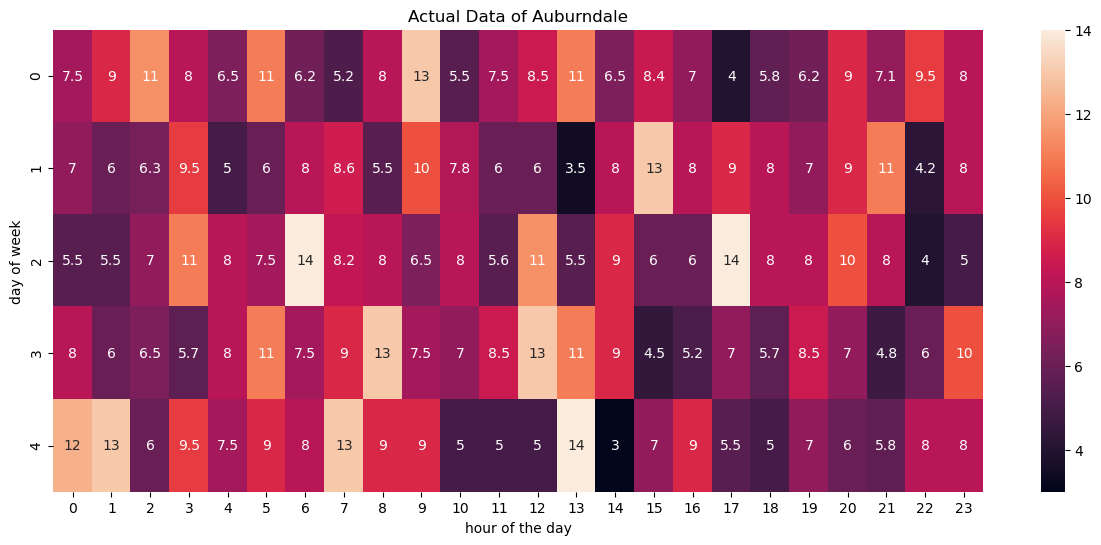

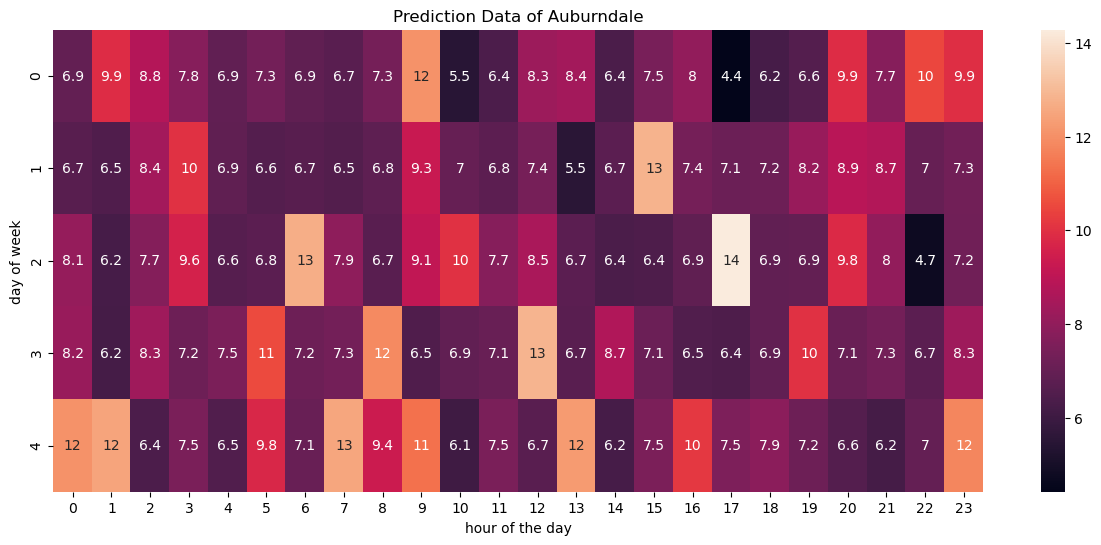

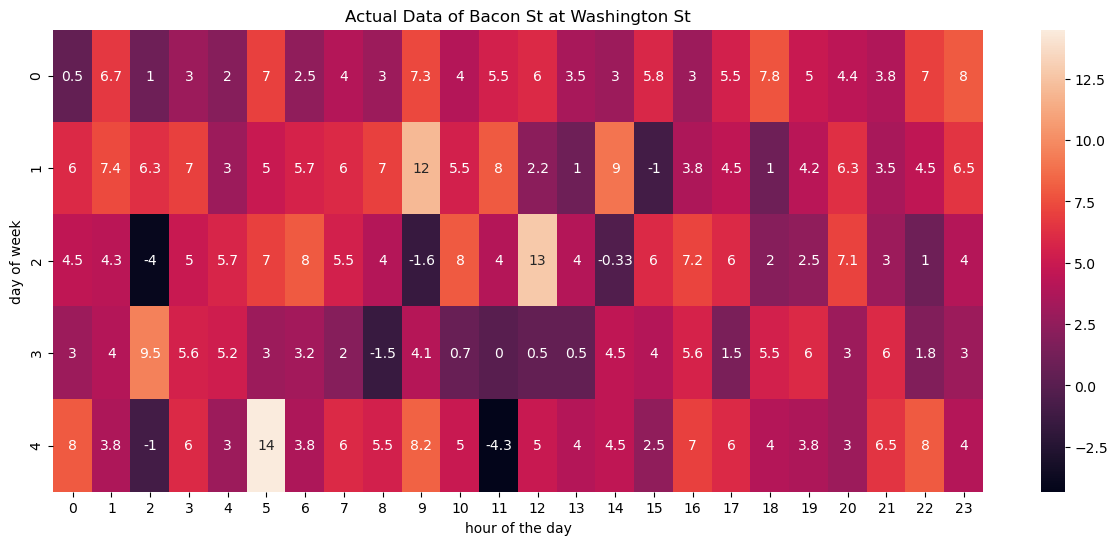

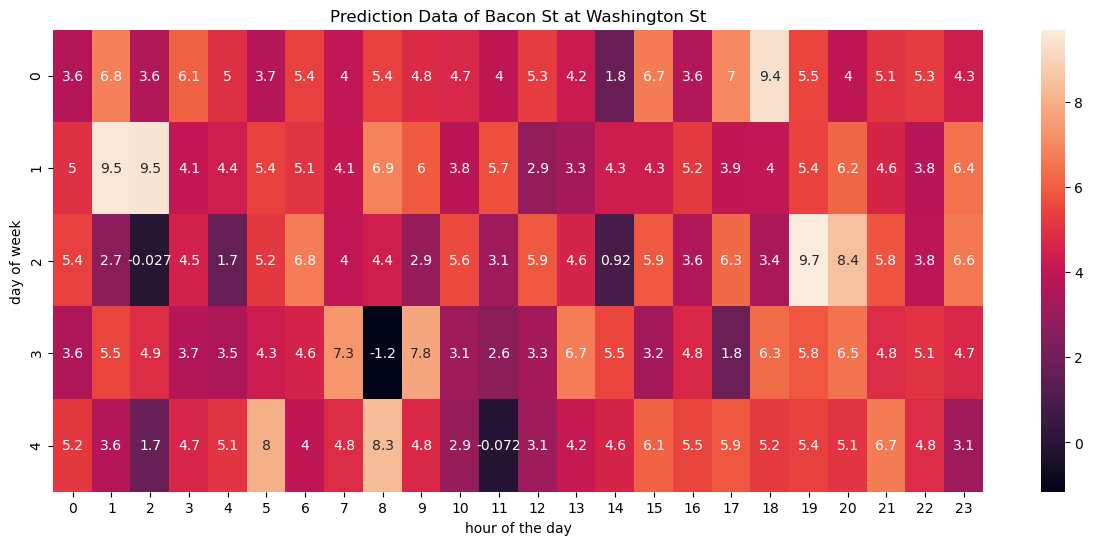

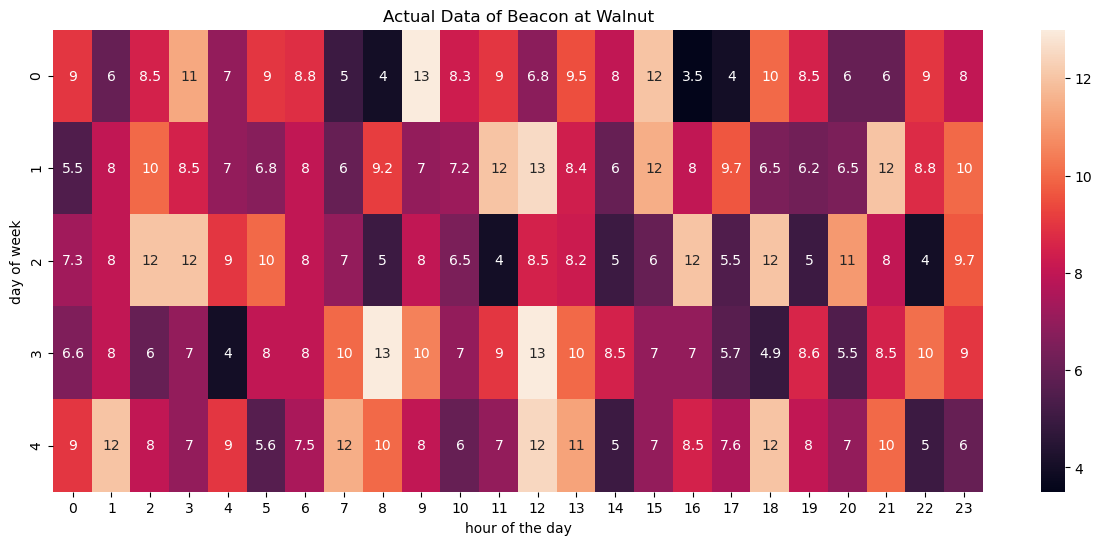

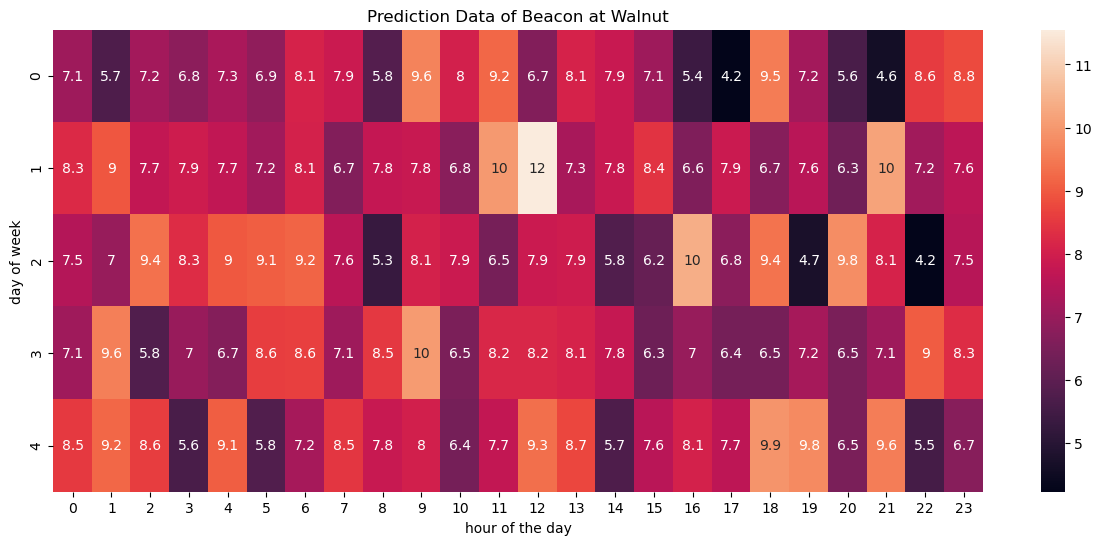

In [47]:
for i in winter_closure.station[:3]:
    plt.figure(figsize=(15, 6))
    sns.heatmap(results[i][1][0], annot=True)
    plt.xlabel("hour of the day")
    plt.ylabel("day of week")
    plt.title(f"Actual Data of {stations.NAME[i]}")
    plt.show()
    plt.figure(figsize=(15, 6))
    sns.heatmap(results[i][2][0], annot=True)
    plt.xlabel("hour of the day")
    plt.ylabel("day of week")
    plt.title(f"Prediction Data of {stations.NAME[i]}")
    plt.show()
        
    

In [20]:
for i in winter_closure.station:
    y_pred = results[i][2].flatten()
    y = results[i][1].flatten()
    # Plotting the actual vs predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.7, label='Predicted vs Actual', color='b')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='r', linestyle='--', label='1:1 Line')
    plt.xlabel('Actual Bike Availability')
    plt.ylabel('Predicted Bike Availability')
    plt.axhline(y=0, color='green', linestyle='--', label='Out of Bikes')
    plt.axhline(y=stations['Total Docks'][i], color='green', linestyle='--', label='Out of Docks')
    plt.axvline(x=2, color='orange', linestyle='--')
    plt.axvline(x=stations['Total Docks'][i], color='orange', linestyle='--')
    plt.title(f'{stations.NAME[i]}')
    plt.legend()
    plt.show()


KeyboardInterrupt



In [148]:
import numpy as np

def calculate_reward(i, j, d, h):

    source_bikes = results[i][2][0][d-1][h-1]
    dest_bikes = results[j][2][0][d-1][h-1]
    max_capacity_dest = stations['Total Docks'][j]
    # Demand difference factor
    demand_diff = max(0, source_bikes - dest_bikes)
    
    # Availability urgency at destination
    availability_urgency = max(0, (max_capacity_dest - dest_bikes) / max_capacity_dest)
    
    # Distance factor (penalize longer distances)
#     distance_penalty = 1 / (1 + distance)
    
    # Peak hour multiplier
#     peak_multiplier = 1.5 if time_of_day in peak_hours else 1.0
    
    # Reward formula
    reward = demand_diff * availability_urgency # * distance_penalty * peak_multiplier
    
    return reward


reward = calculate_reward(193, 287, 4, 12)
print(f"Reward for this move: {reward:.2f}")


Reward for this move: 0.00


In [154]:
pricing = np.zeros((5, 25))
for d in range(5):
    for h in range(24):
        pricing[d][h] = calculate_reward(287, 193, d, h)
pricing

array([[ 0.        ,  1.43297772,  0.        ,  1.76181441,  0.        ,
         0.        ,  1.54040212,  0.04238875,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.94050378,  0.        ,  0.        ,  0.        ,  0.        ,
         1.66336859,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 2.54620063,  0.        ,  0.        ,  1.83691798,  4.21982736,
         2.22261423,  0.        , 14.34775321,  0.        ,  1.47007747,
         0.        ,  0.        ,  3.42124804,  0.        , 14.61998604,
         0.34121497,  5.18866483,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.1218465 ,  0.        ,  0.        ],
       [ 1.78276945,  0.        ,  0.        ,  5.49775539,  3.67727762,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.05355017,  0.        ,  5.92926197,  0.        ,
         7.99915832,  4.35272929,  4.72723916,  0

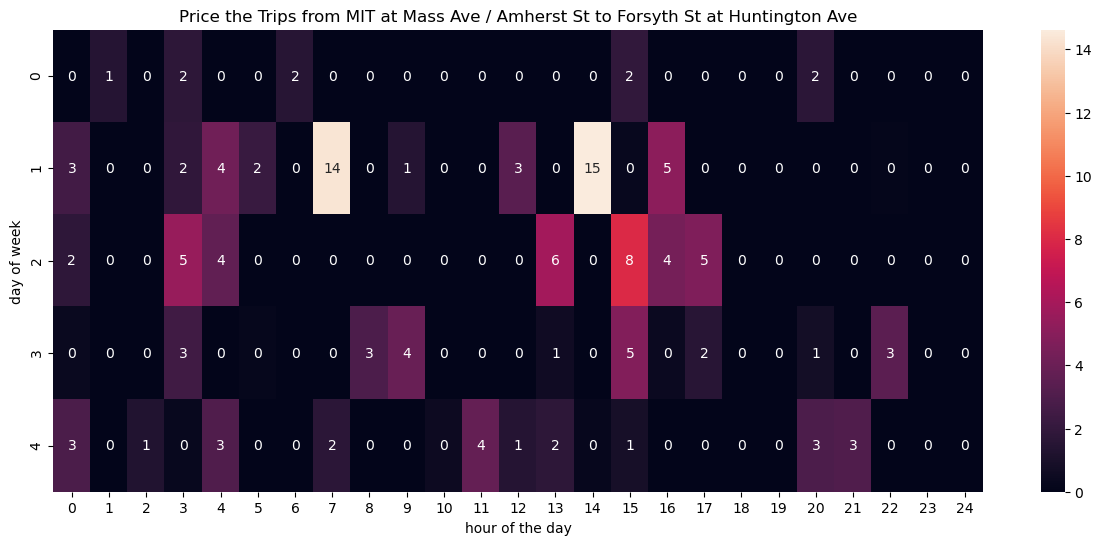

In [156]:
plt.figure(figsize=(15, 6))
sns.heatmap(pricing, annot=True, fmt=".0f")
plt.xlabel("hour of the day")
plt.ylabel("day of week")
plt.title(f"Price the Trips from {stations.NAME[287]} to {stations.NAME[193]}")
plt.show()

In [157]:
def closest_stations(station_idx, stations_df=stations, num_closest=3):
    """
    Find the indices of the closest stations to the given station index.
    
    Parameters:
    - station_idx: Index of the reference station.
    - stations_df: DataFrame with columns ['name', 'longitude', 'latitude', 'total_docks'].
    - num_closest: Number of closest stations to find (default is 3).
    
    Returns:
    - closest_indices: List of indices of the closest stations.
    """
    # Get the coordinates of the reference station
    ref_coords = (stations_df.loc[station_idx, 'Lat'], stations_df.loc[station_idx, 'Long'])
    
    # Compute distances to all other stations
    distances = stations_df.apply(
        lambda row: geodesic(ref_coords, (row['Lat'], row['Long'])).kilometers, axis=1
    )
    
    # Exclude the reference station itself
    distances[station_idx] = np.inf
    
    # Get the indices of the closest stations
    closest_indices = distances.nsmallest(num_closest).index.tolist()
    closest_indices.insert(0, station_idx)
    
    return closest_indices

closest_stations(228)

[228, 127, 227, 225]

In [190]:
def suggest_alternatives(i, j, d, h, delay = 2):
    alternative_stations = np.zeros((4, 4))
    alt_origins = closest_stations(i)
    alt_destinations = closest_stations(j)
    for ai in range(len(alt_origins)):
        for aj in range(len(alt_destinations)):
            alternative_stations[ai][aj] = calculate_reward(alt_origins[ai], alt_destinations[aj], d, h)
    row_names = stations.NAME[alt_origins]
    col_names = stations.NAME[alt_destinations]

    # Create the heatmap
    plt.figure(figsize=(3, 3))
    sns.heatmap(alternative_stations, annot=True, cmap='viridis', xticklabels=col_names, yticklabels=row_names)

    # Add title and labels
    plt.title('Rewards for The Trip and OD Alternatives')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.xlabel('Destinations')
    plt.ylabel('Origins')
    
    time_reward = []
    alternative_times = [x+h for x in range(-delay, delay+1)]
    for alt in alternative_times:
        time_reward.append(calculate_reward(i, j, d, alt))
    
    # Create the heatmap
    plt.figure(figsize=(5, 0.5))
    sns.heatmap(np.array(time_reward).reshape(1, delay*2+1), annot=True, cmap='viridis', xticklabels=alternative_times)

    # Add title and labels
    plt.title('Rewards for The Trip and Time Alternatives')
    plt.xlabel('Hour of Trip')
    
    colormap = plt.cm.get_cmap('RdYlGn')
    m = folium.Map(location=[42.3736, -71.1097], zoom_start=14)
    alt_stations = alt_origins+alt_destinations
    # Add markers for stations
    for idx, row in stations.loc[alt_stations].iterrows():
        color = "green" if idx in alt_origins else "red" if idx in alt_destinations else "blue"
        folium.CircleMarker(
            location=(row['Lat'], row['Long']),
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.9,
            tooltip=row['NAME']
        ).add_to(m)

    # Add connections with variable line thickness
    for i, origin in enumerate(alt_origins):
        for j, destination in enumerate(alt_destinations):
            # Get reward value and normalize it for line thickness
            reward = alternative_stations[i][j]
            normalized_reward = reward / max(max(row) for row in alternative_stations)
            thickness = (reward / max(max(row) for row in alternative_stations)) * 10  # Scale for visualization
            if i == 0 and j == 0:
                line_color = "black"  # Special color for cell (0, 0)
            else:
                rgba_color = colormap(normalized_reward)  # Get RGBA from colormap
                line_color = mcolors.to_hex(rgba_color)
            # Draw line between origin and destination
            folium.PolyLine(
                locations=[
                    (stations.loc[origin, 'Lat'], stations.loc[origin, 'Long']),
                    (stations.loc[destination, 'Lat'], stations.loc[destination, 'Long'])
                ],
                color=line_color,
                weight=thickness,
                opacity=1
            ).add_to(m)
    return m

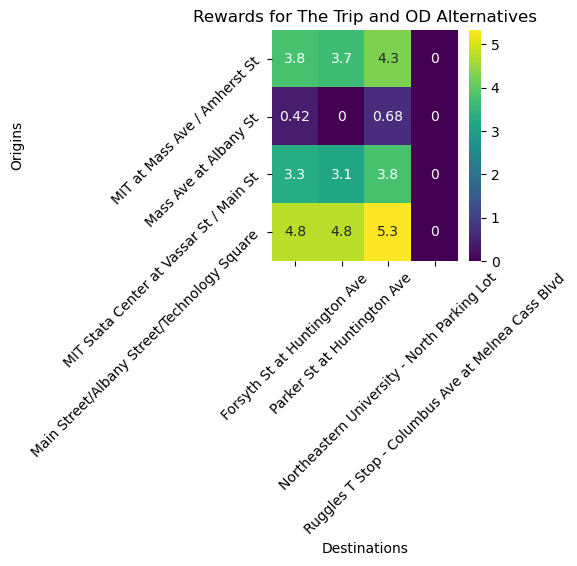

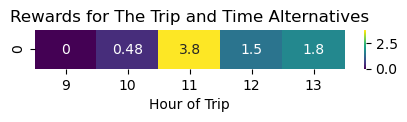

In [191]:
suggest_alternatives(287, 193, 4, 11)